In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import numpy as np
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda:0


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.Sigmoid()

        # input: 100      
        self.fc1 = nn.Linear(in_features=100, out_features=128)    
        self.fc2 = nn.Linear(in_features=128, out_features=784)

        self.sig = nn.Sigmoid()


    
    def forward(self, x):
        x = self.fc1(x) #100->128
        x = self.act(x) #128->128
        x = self.fc2(x) #128->784
        x = self.sig(x) #784->784 (28x28)
        return x

class Generator_loss(nn.Module):
    def __init__(self):
        super(Generator_loss, self).__init__()

    def forward(self, output_fake):
        loss = -torch.log(output_fake)
        return loss.mean()
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.ReLU()

        # input: 784     
        self.fc1 = nn.Linear(in_features=784, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x) #784->128
        x = self.act(x) #128->128
        x_logits = self.fc2(x) #128->1
        x_prob = self.sig(x_logits) #1->1
        return x_prob, x_logits
    
class Discriminator_loss(nn.Module):
    def __init__(self):
        super(Discriminator_loss, self).__init__()

    def forward(self, output_real, output_fake):
        loss = -(torch.log(output_real)+torch.log(1-output_fake))
        return loss.mean()

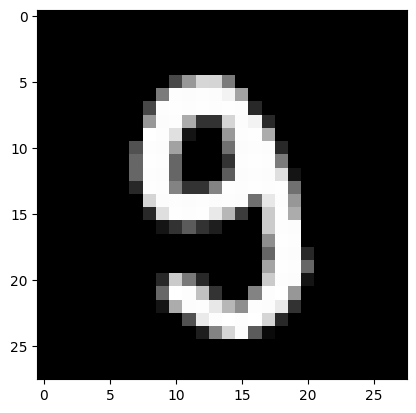

In [3]:
# Define the mini-batch size
batch_size = 100

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

# Dataset is split 8:2
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")

    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

In [4]:
def train_models(model_d, criterion_d, optimizer_d, scheduler_d, model_g, criterion_g, optimizer_g, scheduler_g, epochs, train_loader, k, batch_sz):
    it = iter(train_loader)
    for epoch in range(epochs):
          
        #Train Discriminator 
        for batch_nr in range(k):
            try:
                images,_ = next(it)
            except:
                it = iter(train_loader)
                images,_ = next(it)          
            _, out_real = model_d(torch.flatten(images,start_dim=1).to(device))
            _, out_fake = model_d(model_g(torch.rand(batch_sz,1,100).to(device)))
            optimizer_d.zero_grad()
            loss_d_real = criterion_d(out_real,torch.ones_like(out_real)).to(device)
            loss_d_fake = criterion_d(out_fake,torch.zeros_like(out_fake)).to(device)
            loss_d = loss_d_real+loss_d_fake
            loss_d.backward()
            optimizer_d.step()
            scheduler_d.step()

        #Train Generator
        _, out_fake = model_d(model_g(torch.rand(batch_sz,1,100).to(device)))
        optimizer_g.zero_grad()
        loss_g = criterion_g(out_fake,torch.ones_like(out_fake)).to(device)
        loss_g.backward()
        optimizer_g.step()
        scheduler_g.step()
        
        
        
        if epoch%50==0:
            print("Epoch:",epoch)  
            print("loss_g:",loss_g.item(),"\tloss_d:",loss_d.item())
        if epoch%500==0:
            disp = model_g(torch.rand(batch_sz,1,100).to(device))
            plot_digit(torch.reshape(disp[0,0,:],(28,28)).detach().cpu())

Epoch: 0
loss_g: 1.0517666339874268 	loss_d: 1.2118499279022217


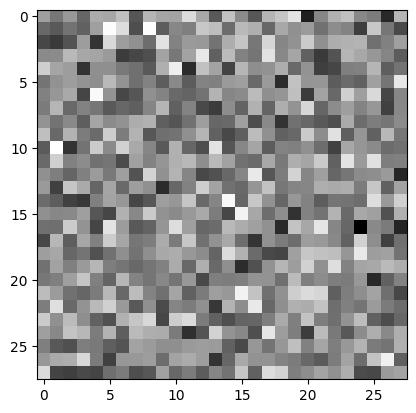

Epoch: 50
loss_g: 4.7703447341918945 	loss_d: 0.04092651233077049
Epoch: 100
loss_g: 4.996453285217285 	loss_d: 0.022856326773762703
Epoch: 150
loss_g: 4.629033088684082 	loss_d: 0.033750537782907486
Epoch: 200
loss_g: 4.052234172821045 	loss_d: 0.057770535349845886
Epoch: 250
loss_g: 3.428894519805908 	loss_d: 0.10709790885448456
Epoch: 300
loss_g: 3.144360065460205 	loss_d: 0.16943427920341492
Epoch: 350
loss_g: 2.7197580337524414 	loss_d: 0.22066722810268402
Epoch: 400
loss_g: 2.80379319190979 	loss_d: 0.19132818281650543
Epoch: 450
loss_g: 2.956937789916992 	loss_d: 0.1489935666322708
Epoch: 500
loss_g: 2.9891068935394287 	loss_d: 0.1258428394794464


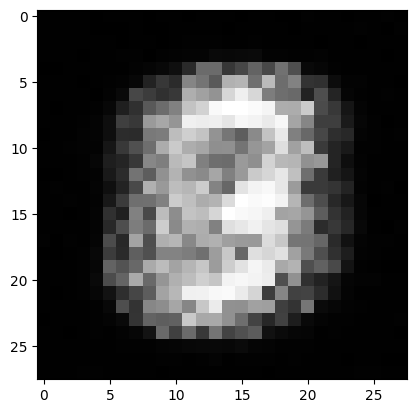

Epoch: 550
loss_g: 2.97627592086792 	loss_d: 0.1434120386838913
Epoch: 600
loss_g: 3.019260883331299 	loss_d: 0.11262432485818863
Epoch: 650
loss_g: 2.4779045581817627 	loss_d: 0.18794646859169006
Epoch: 700
loss_g: 1.7926664352416992 	loss_d: 0.3469286859035492
Epoch: 750
loss_g: 1.525236964225769 	loss_d: 0.4909178912639618
Epoch: 800
loss_g: 1.7942516803741455 	loss_d: 0.2834472060203552
Epoch: 850
loss_g: 2.287714719772339 	loss_d: 0.1740826815366745
Epoch: 900
loss_g: 2.637507200241089 	loss_d: 0.0988268032670021
Epoch: 950
loss_g: 2.78885555267334 	loss_d: 0.10931050777435303
Epoch: 1000
loss_g: 3.187714099884033 	loss_d: 0.06447107344865799


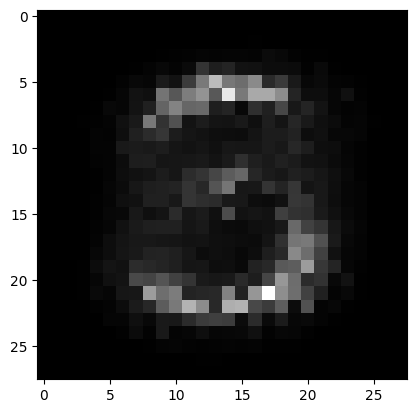

Epoch: 1050
loss_g: 3.117882013320923 	loss_d: 0.07442229241132736
Epoch: 1100
loss_g: 3.3027734756469727 	loss_d: 0.06676246225833893
Epoch: 1150
loss_g: 3.021949291229248 	loss_d: 0.1251257359981537
Epoch: 1200
loss_g: 2.967670202255249 	loss_d: 0.09788718819618225
Epoch: 1250
loss_g: 3.036731004714966 	loss_d: 0.14249669015407562
Epoch: 1300
loss_g: 3.107697010040283 	loss_d: 0.10937505960464478
Epoch: 1350
loss_g: 3.2533934116363525 	loss_d: 0.09364742040634155
Epoch: 1400
loss_g: 3.2287819385528564 	loss_d: 0.1312805712223053
Epoch: 1450
loss_g: 3.427408456802368 	loss_d: 0.09124760329723358
Epoch: 1500
loss_g: 3.6419568061828613 	loss_d: 0.06429050117731094


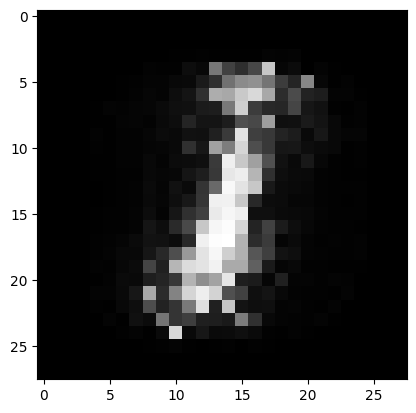

Epoch: 1550
loss_g: 3.5051050186157227 	loss_d: 0.07554515451192856
Epoch: 1600
loss_g: 3.913602113723755 	loss_d: 0.05422660708427429
Epoch: 1650
loss_g: 4.052505970001221 	loss_d: 0.034275270998477936
Epoch: 1700
loss_g: 3.8255910873413086 	loss_d: 0.06016916036605835
Epoch: 1750
loss_g: 3.5095040798187256 	loss_d: 0.10015515983104706
Epoch: 1800
loss_g: 3.7852776050567627 	loss_d: 0.04596031457185745
Epoch: 1850
loss_g: 3.769026517868042 	loss_d: 0.047494471073150635
Epoch: 1900
loss_g: 3.6622254848480225 	loss_d: 0.049696825444698334
Epoch: 1950
loss_g: 3.6345362663269043 	loss_d: 0.04685351625084877
Epoch: 2000
loss_g: 3.596527338027954 	loss_d: 0.043947335332632065


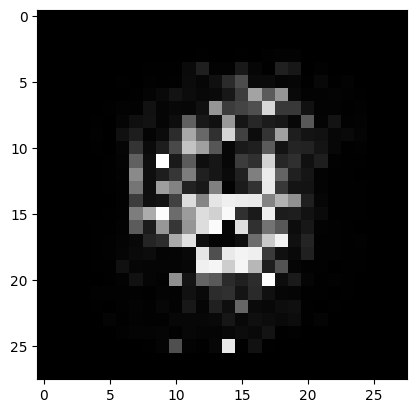

Epoch: 2050
loss_g: 3.7162423133850098 	loss_d: 0.06619524210691452
Epoch: 2100
loss_g: 3.628532648086548 	loss_d: 0.07157838344573975
Epoch: 2150
loss_g: 3.4472668170928955 	loss_d: 0.05496813729405403
Epoch: 2200
loss_g: 3.664490222930908 	loss_d: 0.04297087714076042
Epoch: 2250
loss_g: 3.7822940349578857 	loss_d: 0.0447351448237896
Epoch: 2300
loss_g: 3.709388256072998 	loss_d: 0.05416231229901314
Epoch: 2350
loss_g: 3.708303451538086 	loss_d: 0.0404689759016037
Epoch: 2400
loss_g: 3.776118278503418 	loss_d: 0.05956031382083893
Epoch: 2450
loss_g: 4.022369384765625 	loss_d: 0.038644082844257355
Epoch: 2500
loss_g: 3.915517807006836 	loss_d: 0.053901828825473785


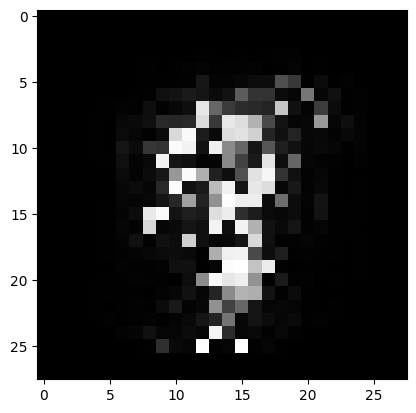

Epoch: 2550
loss_g: 3.7338757514953613 	loss_d: 0.034372009336948395
Epoch: 2600
loss_g: 3.861666440963745 	loss_d: 0.03879057615995407
Epoch: 2650
loss_g: 3.670109272003174 	loss_d: 0.091389961540699
Epoch: 2700
loss_g: 3.878814220428467 	loss_d: 0.05254140496253967
Epoch: 2750
loss_g: 3.5773026943206787 	loss_d: 0.07540144771337509
Epoch: 2800
loss_g: 3.678349018096924 	loss_d: 0.06429703533649445
Epoch: 2850
loss_g: 3.761700391769409 	loss_d: 0.058335766196250916
Epoch: 2900
loss_g: 3.5540707111358643 	loss_d: 0.0624225027859211
Epoch: 2950
loss_g: 3.8009450435638428 	loss_d: 0.03624320775270462
Epoch: 3000
loss_g: 3.9735348224639893 	loss_d: 0.04428365081548691


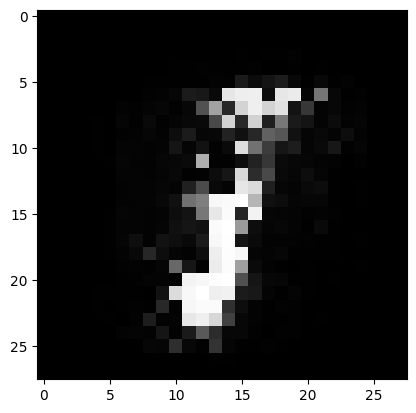

Epoch: 3050
loss_g: 3.6621294021606445 	loss_d: 0.07196289300918579
Epoch: 3100
loss_g: 3.745095729827881 	loss_d: 0.07500485330820084
Epoch: 3150
loss_g: 3.608065366744995 	loss_d: 0.05006346479058266
Epoch: 3200
loss_g: 3.674654960632324 	loss_d: 0.055104129016399384
Epoch: 3250
loss_g: 3.8396105766296387 	loss_d: 0.03695821762084961
Epoch: 3300
loss_g: 3.7125070095062256 	loss_d: 0.050284355878829956
Epoch: 3350
loss_g: 3.9483611583709717 	loss_d: 0.05670653283596039
Epoch: 3400
loss_g: 3.7619879245758057 	loss_d: 0.04967479407787323
Epoch: 3450
loss_g: 3.492523670196533 	loss_d: 0.07500466704368591
Epoch: 3500
loss_g: 3.620851993560791 	loss_d: 0.0737498551607132


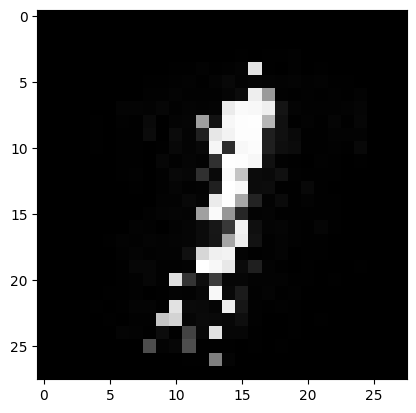

Epoch: 3550
loss_g: 3.608348846435547 	loss_d: 0.0659954622387886
Epoch: 3600
loss_g: 3.735978364944458 	loss_d: 0.044943396002054214
Epoch: 3650
loss_g: 4.031277656555176 	loss_d: 0.05041784793138504
Epoch: 3700
loss_g: 3.882166624069214 	loss_d: 0.06034137308597565
Epoch: 3750
loss_g: 4.3096723556518555 	loss_d: 0.03198675438761711
Epoch: 3800
loss_g: 4.443867206573486 	loss_d: 0.03895488381385803
Epoch: 3850
loss_g: 4.254343032836914 	loss_d: 0.03594396635890007
Epoch: 3900
loss_g: 3.850642681121826 	loss_d: 0.04191317409276962
Epoch: 3950
loss_g: 3.9232983589172363 	loss_d: 0.07673274725675583
Epoch: 4000
loss_g: 4.111811637878418 	loss_d: 0.04001544415950775


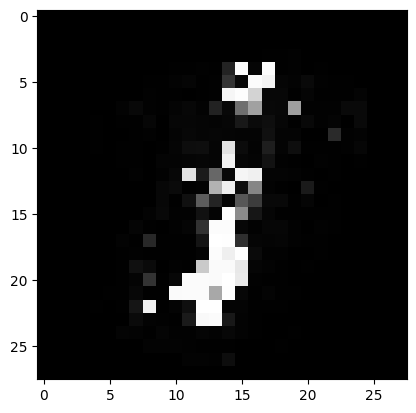

Epoch: 4050
loss_g: 3.875596761703491 	loss_d: 0.055879026651382446
Epoch: 4100
loss_g: 4.00005578994751 	loss_d: 0.055596038699150085
Epoch: 4150
loss_g: 4.0364766120910645 	loss_d: 0.02450135536491871
Epoch: 4200
loss_g: 3.9759368896484375 	loss_d: 0.024996373802423477
Epoch: 4250
loss_g: 4.074497222900391 	loss_d: 0.02550162747502327
Epoch: 4300
loss_g: 4.228567600250244 	loss_d: 0.033475957810878754
Epoch: 4350
loss_g: 4.142085075378418 	loss_d: 0.02967037260532379
Epoch: 4400
loss_g: 4.152548313140869 	loss_d: 0.052029795944690704
Epoch: 4450
loss_g: 4.2826457023620605 	loss_d: 0.030378539115190506
Epoch: 4500
loss_g: 3.713184356689453 	loss_d: 0.05931665375828743


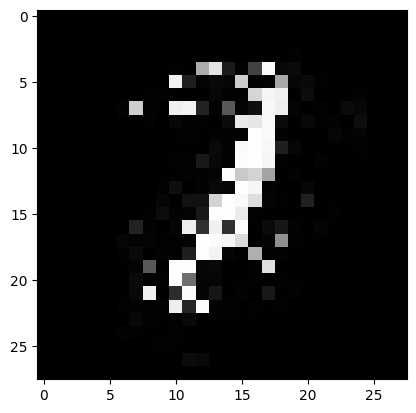

Epoch: 4550
loss_g: 3.8995463848114014 	loss_d: 0.03211597725749016
Epoch: 4600
loss_g: 3.839925527572632 	loss_d: 0.0326727032661438
Epoch: 4650
loss_g: 3.9013235569000244 	loss_d: 0.02682148478925228
Epoch: 4700
loss_g: 3.779886484146118 	loss_d: 0.03545213118195534
Epoch: 4750
loss_g: 3.7471959590911865 	loss_d: 0.05429496616125107
Epoch: 4800
loss_g: 3.778872489929199 	loss_d: 0.059808723628520966
Epoch: 4850
loss_g: 3.775097608566284 	loss_d: 0.0592278428375721
Epoch: 4900
loss_g: 3.976975202560425 	loss_d: 0.029901614412665367
Epoch: 4950
loss_g: 4.022405624389648 	loss_d: 0.024873021990060806
Epoch: 5000
loss_g: 3.9459471702575684 	loss_d: 0.027677418664097786


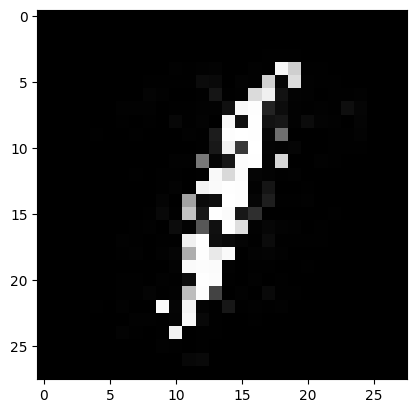

Epoch: 5050
loss_g: 3.843503952026367 	loss_d: 0.0468527227640152
Epoch: 5100
loss_g: 3.698270082473755 	loss_d: 0.033309269696474075
Epoch: 5150
loss_g: 3.7096667289733887 	loss_d: 0.04138316959142685
Epoch: 5200
loss_g: 3.6992242336273193 	loss_d: 0.03642492741346359
Epoch: 5250
loss_g: 3.64035701751709 	loss_d: 0.0819384977221489
Epoch: 5300
loss_g: 3.58052396774292 	loss_d: 0.14586907625198364
Epoch: 5350
loss_g: 3.5464513301849365 	loss_d: 0.03713889420032501
Epoch: 5400
loss_g: 3.6561520099639893 	loss_d: 0.04845372959971428
Epoch: 5450
loss_g: 3.7960264682769775 	loss_d: 0.02792704664170742
Epoch: 5500
loss_g: 4.189640998840332 	loss_d: 0.018496578559279442


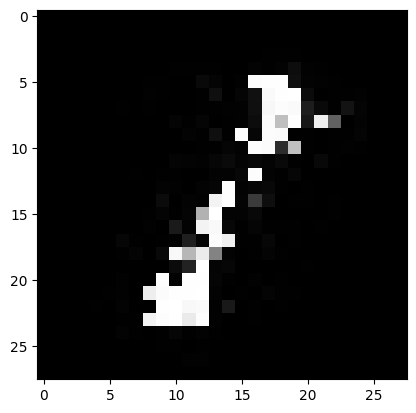

Epoch: 5550
loss_g: 4.104449272155762 	loss_d: 0.030280301347374916
Epoch: 5600
loss_g: 4.170093059539795 	loss_d: 0.022520190104842186
Epoch: 5650
loss_g: 3.7860655784606934 	loss_d: 0.05320291221141815
Epoch: 5700
loss_g: 3.8201849460601807 	loss_d: 0.06268730014562607
Epoch: 5750
loss_g: 3.8626153469085693 	loss_d: 0.05025860667228699
Epoch: 5800
loss_g: 4.106502532958984 	loss_d: 0.042721234261989594
Epoch: 5850
loss_g: 4.437044143676758 	loss_d: 0.02224314957857132
Epoch: 5900
loss_g: 4.328558444976807 	loss_d: 0.016400553286075592
Epoch: 5950
loss_g: 4.303515434265137 	loss_d: 0.04387904703617096
Epoch: 6000
loss_g: 4.036643981933594 	loss_d: 0.02637159451842308


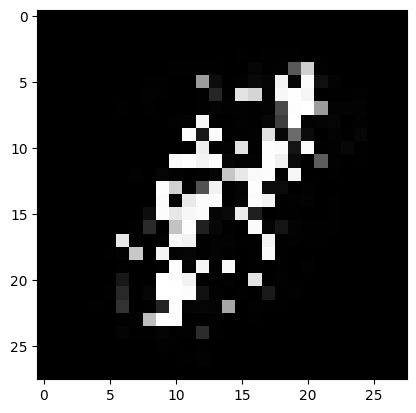

Epoch: 6050
loss_g: 4.017688274383545 	loss_d: 0.03557903319597244
Epoch: 6100
loss_g: 4.12478494644165 	loss_d: 0.024384554475545883
Epoch: 6150
loss_g: 4.236583709716797 	loss_d: 0.023722432553768158
Epoch: 6200
loss_g: 4.115711688995361 	loss_d: 0.03484250605106354
Epoch: 6250
loss_g: 4.327469825744629 	loss_d: 0.02728511393070221
Epoch: 6300
loss_g: 4.307033538818359 	loss_d: 0.035945966839790344
Epoch: 6350
loss_g: 4.01539945602417 	loss_d: 0.030964158475399017
Epoch: 6400
loss_g: 3.814829111099243 	loss_d: 0.05323565751314163
Epoch: 6450
loss_g: 3.6954185962677 	loss_d: 0.03794027119874954
Epoch: 6500
loss_g: 3.9628746509552 	loss_d: 0.048589788377285004


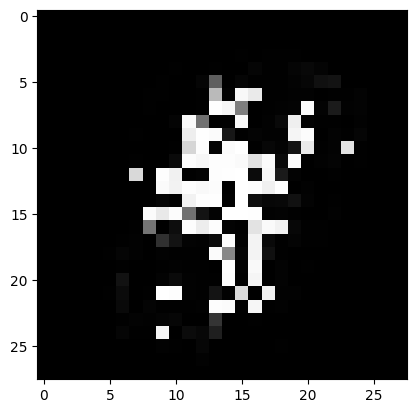

Epoch: 6550
loss_g: 3.8300700187683105 	loss_d: 0.04708319157361984
Epoch: 6600
loss_g: 3.7089834213256836 	loss_d: 0.061833545565605164
Epoch: 6650
loss_g: 3.593709707260132 	loss_d: 0.0961882621049881
Epoch: 6700
loss_g: 3.5461840629577637 	loss_d: 0.08327102661132812
Epoch: 6750
loss_g: 3.5963025093078613 	loss_d: 0.03152741491794586
Epoch: 6800
loss_g: 3.4900753498077393 	loss_d: 0.07620347291231155
Epoch: 6850
loss_g: 3.5307507514953613 	loss_d: 0.06507067382335663
Epoch: 6900
loss_g: 3.487727642059326 	loss_d: 0.07601836323738098
Epoch: 6950
loss_g: 3.9512205123901367 	loss_d: 0.05336907505989075
Epoch: 7000
loss_g: 3.8268203735351562 	loss_d: 0.07270985841751099


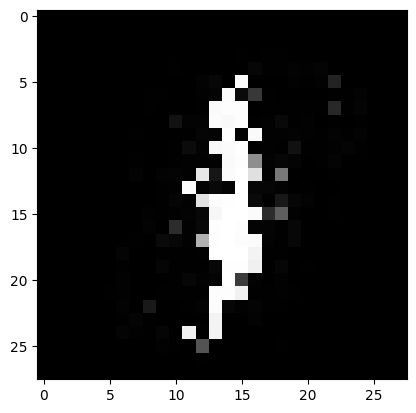

Epoch: 7050
loss_g: 3.885676860809326 	loss_d: 0.0388808399438858
Epoch: 7100
loss_g: 3.4968645572662354 	loss_d: 0.081898994743824
Epoch: 7150
loss_g: 3.273364782333374 	loss_d: 0.12636695802211761
Epoch: 7200
loss_g: 3.3221685886383057 	loss_d: 0.09306605160236359
Epoch: 7250
loss_g: 3.4053900241851807 	loss_d: 0.05026722699403763
Epoch: 7300
loss_g: 3.4787230491638184 	loss_d: 0.06050276756286621
Epoch: 7350
loss_g: 3.645005464553833 	loss_d: 0.05136970058083534
Epoch: 7400
loss_g: 3.787175416946411 	loss_d: 0.06575503945350647
Epoch: 7450
loss_g: 3.8104023933410645 	loss_d: 0.031593259423971176
Epoch: 7500
loss_g: 3.65093731880188 	loss_d: 0.04928915947675705


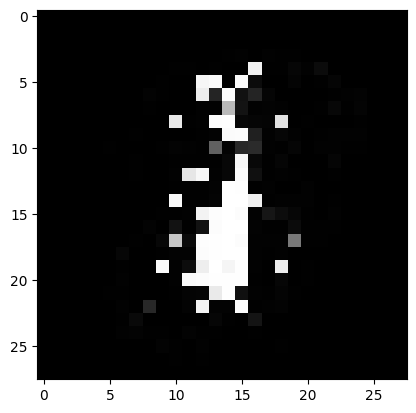

Epoch: 7550
loss_g: 3.74416184425354 	loss_d: 0.05461897328495979
Epoch: 7600
loss_g: 3.6923818588256836 	loss_d: 0.05170900747179985
Epoch: 7650
loss_g: 3.91995906829834 	loss_d: 0.03389092907309532
Epoch: 7700
loss_g: 3.53824782371521 	loss_d: 0.05956098437309265
Epoch: 7750
loss_g: 3.5420472621917725 	loss_d: 0.058390408754348755
Epoch: 7800
loss_g: 3.6041746139526367 	loss_d: 0.0663023591041565
Epoch: 7850
loss_g: 3.306678295135498 	loss_d: 0.08382253348827362
Epoch: 7900
loss_g: 3.302802324295044 	loss_d: 0.08875395357608795
Epoch: 7950
loss_g: 3.539431095123291 	loss_d: 0.0641070306301117
Epoch: 8000
loss_g: 3.5160772800445557 	loss_d: 0.07077185809612274


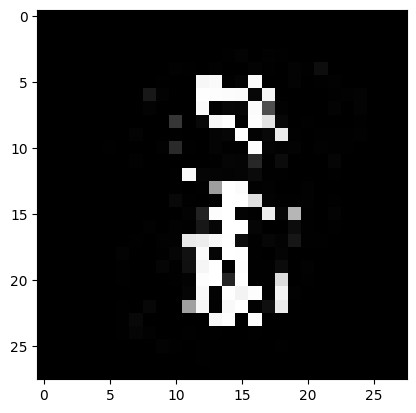

Epoch: 8050
loss_g: 3.5925707817077637 	loss_d: 0.062396541237831116
Epoch: 8100
loss_g: 3.5255753993988037 	loss_d: 0.07474367320537567
Epoch: 8150
loss_g: 3.6706199645996094 	loss_d: 0.06386253237724304
Epoch: 8200
loss_g: 3.5960826873779297 	loss_d: 0.06527692079544067
Epoch: 8250
loss_g: 3.756558656692505 	loss_d: 0.08423875272274017
Epoch: 8300
loss_g: 3.408864974975586 	loss_d: 0.048496391624212265
Epoch: 8350
loss_g: 3.2487361431121826 	loss_d: 0.09856186807155609
Epoch: 8400
loss_g: 3.4651975631713867 	loss_d: 0.07889357209205627
Epoch: 8450
loss_g: 3.290053367614746 	loss_d: 0.07812514901161194
Epoch: 8500
loss_g: 3.421576499938965 	loss_d: 0.07573029398918152


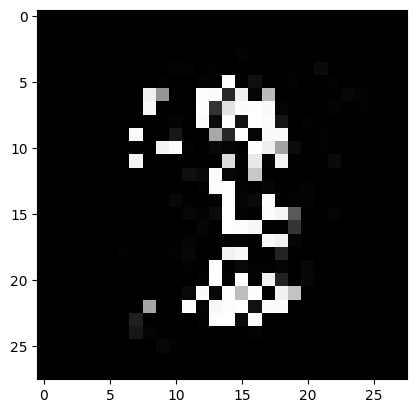

Epoch: 8550
loss_g: 2.9044368267059326 	loss_d: 0.13125576078891754
Epoch: 8600
loss_g: 3.560826539993286 	loss_d: 0.08242917060852051
Epoch: 8650
loss_g: 3.5655088424682617 	loss_d: 0.10170326381921768
Epoch: 8700
loss_g: 3.533829689025879 	loss_d: 0.04995649307966232
Epoch: 8750
loss_g: 3.5189549922943115 	loss_d: 0.07261630147695541
Epoch: 8800
loss_g: 3.5239946842193604 	loss_d: 0.06169261783361435
Epoch: 8850
loss_g: 3.249626398086548 	loss_d: 0.10278277099132538
Epoch: 8900
loss_g: 3.3688440322875977 	loss_d: 0.13405191898345947
Epoch: 8950
loss_g: 3.344996452331543 	loss_d: 0.06485457718372345
Epoch: 9000
loss_g: 3.399534225463867 	loss_d: 0.08396553248167038


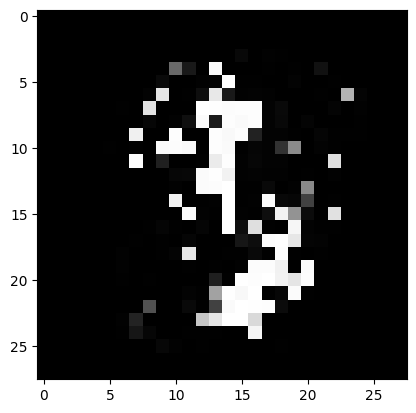

Epoch: 9050
loss_g: 3.264589786529541 	loss_d: 0.10581482201814651
Epoch: 9100
loss_g: 3.1326446533203125 	loss_d: 0.09725150465965271
Epoch: 9150
loss_g: 3.4688854217529297 	loss_d: 0.06208515912294388
Epoch: 9200
loss_g: 3.6718380451202393 	loss_d: 0.09037120640277863
Epoch: 9250
loss_g: 3.3981785774230957 	loss_d: 0.0625542476773262
Epoch: 9300
loss_g: 3.3036112785339355 	loss_d: 0.08525944501161575
Epoch: 9350
loss_g: 3.248244285583496 	loss_d: 0.06097788363695145
Epoch: 9400
loss_g: 3.081455707550049 	loss_d: 0.19636531174182892
Epoch: 9450
loss_g: 3.2099664211273193 	loss_d: 0.07098967581987381
Epoch: 9500
loss_g: 3.4932758808135986 	loss_d: 0.0934801697731018


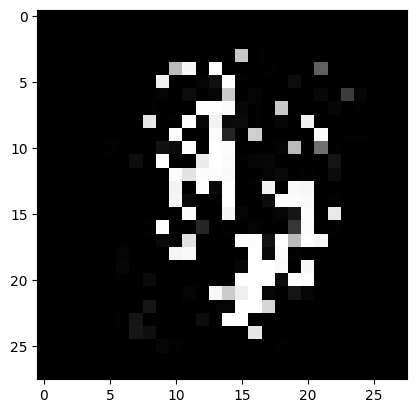

Epoch: 9550
loss_g: 3.2279326915740967 	loss_d: 0.1115526631474495
Epoch: 9600
loss_g: 3.1390130519866943 	loss_d: 0.11861078441143036
Epoch: 9650
loss_g: 3.2830681800842285 	loss_d: 0.11387211829423904
Epoch: 9700
loss_g: 3.516498327255249 	loss_d: 0.10539726167917252
Epoch: 9750
loss_g: 3.4656622409820557 	loss_d: 0.09288114309310913
Epoch: 9800
loss_g: 3.2008073329925537 	loss_d: 0.11797387897968292
Epoch: 9850
loss_g: 3.36630916595459 	loss_d: 0.08766406774520874
Epoch: 9900
loss_g: 3.112017869949341 	loss_d: 0.11015664041042328
Epoch: 9950
loss_g: 3.2039031982421875 	loss_d: 0.11229754984378815
Epoch: 10000
loss_g: 2.920302629470825 	loss_d: 0.08587519824504852


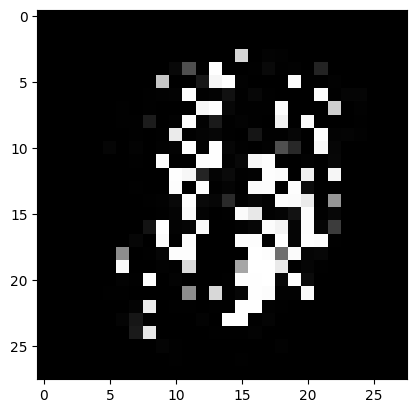

Epoch: 10050
loss_g: 3.509007453918457 	loss_d: 0.08315925300121307
Epoch: 10100
loss_g: 3.590428352355957 	loss_d: 0.05213719978928566
Epoch: 10150
loss_g: 3.3386495113372803 	loss_d: 0.09898509085178375
Epoch: 10200
loss_g: 2.9533159732818604 	loss_d: 0.10229745507240295
Epoch: 10250
loss_g: 3.30383038520813 	loss_d: 0.09900370985269547
Epoch: 10300
loss_g: 3.4205808639526367 	loss_d: 0.0921684205532074
Epoch: 10350
loss_g: 3.5928359031677246 	loss_d: 0.05635734647512436
Epoch: 10400
loss_g: 3.631704092025757 	loss_d: 0.05946558341383934
Epoch: 10450
loss_g: 3.505923271179199 	loss_d: 0.11696847528219223
Epoch: 10500
loss_g: 3.6510157585144043 	loss_d: 0.09459283202886581


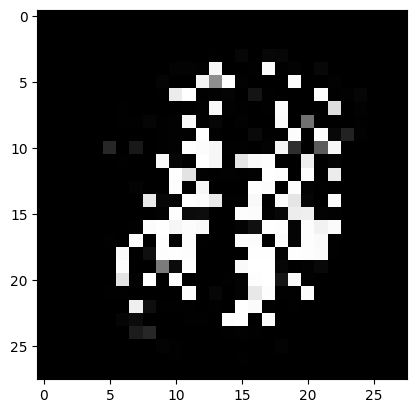

Epoch: 10550
loss_g: 3.522407054901123 	loss_d: 0.07206109911203384
Epoch: 10600
loss_g: 3.394761323928833 	loss_d: 0.06048457324504852
Epoch: 10650
loss_g: 2.9800827503204346 	loss_d: 0.1481529325246811
Epoch: 10700
loss_g: 2.9464938640594482 	loss_d: 0.12652269005775452
Epoch: 10750
loss_g: 3.229848623275757 	loss_d: 0.11895252764225006
Epoch: 10800
loss_g: 3.4058923721313477 	loss_d: 0.1054408848285675
Epoch: 10850
loss_g: 3.6093215942382812 	loss_d: 0.10248300433158875
Epoch: 10900
loss_g: 3.172147750854492 	loss_d: 0.14364376664161682
Epoch: 10950
loss_g: 3.272524356842041 	loss_d: 0.10916084051132202
Epoch: 11000
loss_g: 3.2609167098999023 	loss_d: 0.16690200567245483


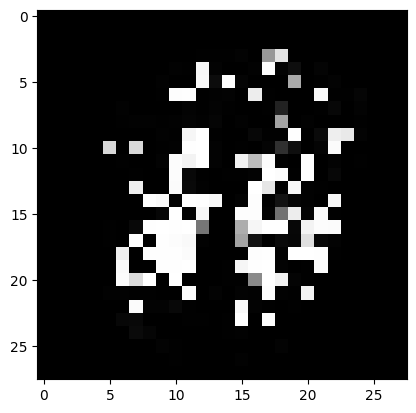

Epoch: 11050
loss_g: 3.3409030437469482 	loss_d: 0.1627371460199356
Epoch: 11100
loss_g: 3.2096476554870605 	loss_d: 0.074244424700737
Epoch: 11150
loss_g: 3.200305938720703 	loss_d: 0.12310172617435455
Epoch: 11200
loss_g: 3.4182963371276855 	loss_d: 0.05565832555294037
Epoch: 11250
loss_g: 3.6172611713409424 	loss_d: 0.11178432404994965
Epoch: 11300
loss_g: 3.568549156188965 	loss_d: 0.07961166650056839
Epoch: 11350
loss_g: 3.0292656421661377 	loss_d: 0.14236459136009216
Epoch: 11400
loss_g: 3.2787206172943115 	loss_d: 0.082717165350914
Epoch: 11450
loss_g: 3.381842613220215 	loss_d: 0.09580076485872269
Epoch: 11500
loss_g: 3.454289436340332 	loss_d: 0.06290578097105026


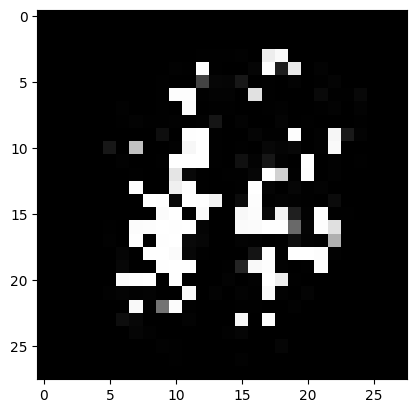

Epoch: 11550
loss_g: 3.4812169075012207 	loss_d: 0.09319852292537689
Epoch: 11600
loss_g: 3.1171276569366455 	loss_d: 0.0868237167596817
Epoch: 11650
loss_g: 3.216588020324707 	loss_d: 0.07690246403217316
Epoch: 11700
loss_g: 3.067002534866333 	loss_d: 0.08848227560520172
Epoch: 11750
loss_g: 3.3981029987335205 	loss_d: 0.09315904974937439
Epoch: 11800
loss_g: 3.569488763809204 	loss_d: 0.04752084240317345
Epoch: 11850
loss_g: 3.3716273307800293 	loss_d: 0.05136272311210632
Epoch: 11900
loss_g: 3.3563108444213867 	loss_d: 0.05738643929362297
Epoch: 11950
loss_g: 3.1399693489074707 	loss_d: 0.07604716718196869
Epoch: 12000
loss_g: 3.057880401611328 	loss_d: 0.11092904210090637


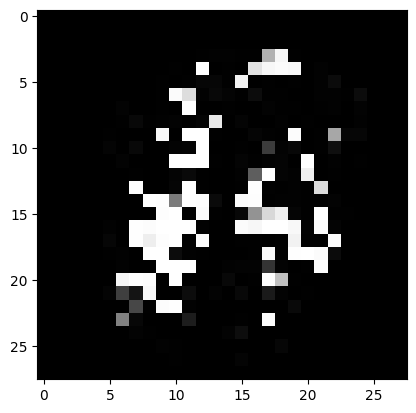

Epoch: 12050
loss_g: 3.0025341510772705 	loss_d: 0.10917908698320389
Epoch: 12100
loss_g: 3.148841142654419 	loss_d: 0.06576350331306458
Epoch: 12150
loss_g: 3.2940073013305664 	loss_d: 0.09520198404788971
Epoch: 12200
loss_g: 3.25917387008667 	loss_d: 0.1317417323589325
Epoch: 12250
loss_g: 3.3445708751678467 	loss_d: 0.09621690213680267
Epoch: 12300
loss_g: 2.9825732707977295 	loss_d: 0.14723065495491028
Epoch: 12350
loss_g: 2.824537515640259 	loss_d: 0.12646743655204773
Epoch: 12400
loss_g: 3.0978519916534424 	loss_d: 0.0678015649318695
Epoch: 12450
loss_g: 2.8481314182281494 	loss_d: 0.11824539303779602
Epoch: 12500
loss_g: 2.5022659301757812 	loss_d: 0.1625705063343048


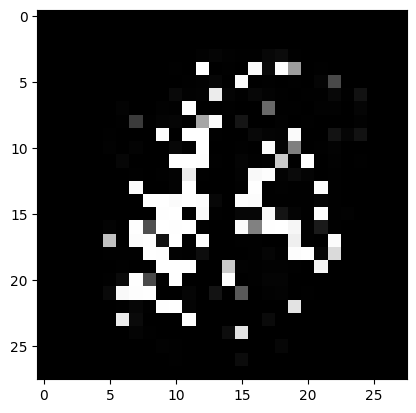

Epoch: 12550
loss_g: 2.8432044982910156 	loss_d: 0.12021678686141968
Epoch: 12600
loss_g: 2.9582202434539795 	loss_d: 0.12540005147457123
Epoch: 12650
loss_g: 2.8423192501068115 	loss_d: 0.1972251832485199
Epoch: 12700
loss_g: 3.1247332096099854 	loss_d: 0.12466326355934143
Epoch: 12750
loss_g: 3.3262410163879395 	loss_d: 0.10113876312971115
Epoch: 12800
loss_g: 2.799358367919922 	loss_d: 0.13567179441452026
Epoch: 12850
loss_g: 2.6840322017669678 	loss_d: 0.1368791162967682
Epoch: 12900
loss_g: 2.9033915996551514 	loss_d: 0.18244203925132751
Epoch: 12950
loss_g: 3.053741455078125 	loss_d: 0.1567443162202835
Epoch: 13000
loss_g: 2.9974870681762695 	loss_d: 0.10617135465145111


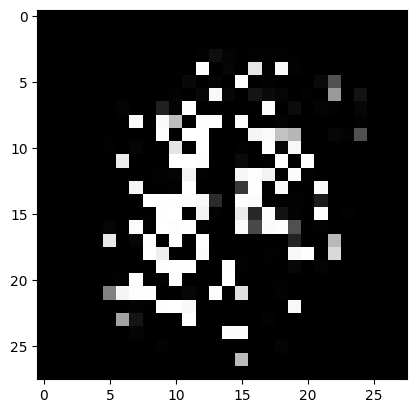

Epoch: 13050
loss_g: 2.773367166519165 	loss_d: 0.13668504357337952
Epoch: 13100
loss_g: 2.716233968734741 	loss_d: 0.2070537507534027
Epoch: 13150
loss_g: 2.7948617935180664 	loss_d: 0.26617565751075745
Epoch: 13200
loss_g: 2.872729778289795 	loss_d: 0.10466794669628143
Epoch: 13250
loss_g: 2.7051329612731934 	loss_d: 0.19596844911575317
Epoch: 13300
loss_g: 2.73170804977417 	loss_d: 0.21799972653388977
Epoch: 13350
loss_g: 2.597313165664673 	loss_d: 0.18040591478347778
Epoch: 13400
loss_g: 2.5917491912841797 	loss_d: 0.2520259618759155
Epoch: 13450
loss_g: 2.0994458198547363 	loss_d: 0.33829379081726074
Epoch: 13500
loss_g: 2.0980818271636963 	loss_d: 0.25447502732276917


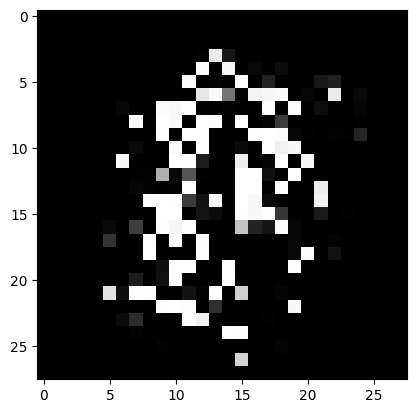

Epoch: 13550
loss_g: 2.3256168365478516 	loss_d: 0.21790850162506104
Epoch: 13600
loss_g: 2.6561508178710938 	loss_d: 0.1851406991481781
Epoch: 13650
loss_g: 2.6090478897094727 	loss_d: 0.3287743628025055
Epoch: 13700
loss_g: 2.296130418777466 	loss_d: 0.27462881803512573
Epoch: 13750
loss_g: 2.3090970516204834 	loss_d: 0.43786075711250305
Epoch: 13800
loss_g: 2.3561348915100098 	loss_d: 0.2752561569213867
Epoch: 13850
loss_g: 2.3222033977508545 	loss_d: 0.3829813301563263
Epoch: 13900
loss_g: 2.5784754753112793 	loss_d: 0.28714901208877563
Epoch: 13950
loss_g: 2.4871585369110107 	loss_d: 0.2656444311141968
Epoch: 14000
loss_g: 2.5826568603515625 	loss_d: 0.24609649181365967


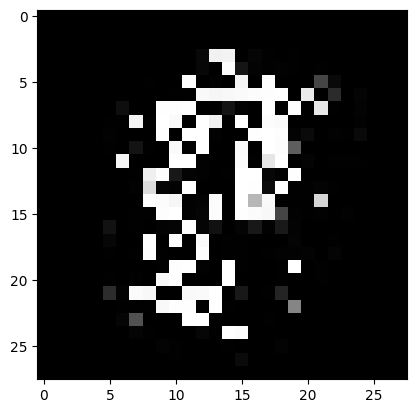

Epoch: 14050
loss_g: 2.6701579093933105 	loss_d: 0.32854950428009033
Epoch: 14100
loss_g: 2.5203115940093994 	loss_d: 0.2046031355857849
Epoch: 14150
loss_g: 2.5682592391967773 	loss_d: 0.21407827734947205
Epoch: 14200
loss_g: 2.4324514865875244 	loss_d: 0.20084455609321594
Epoch: 14250
loss_g: 2.1469674110412598 	loss_d: 0.20665228366851807
Epoch: 14300
loss_g: 2.407926321029663 	loss_d: 0.2115040421485901
Epoch: 14350
loss_g: 2.368692636489868 	loss_d: 0.25586768984794617
Epoch: 14400
loss_g: 2.3445639610290527 	loss_d: 0.3317506015300751
Epoch: 14450
loss_g: 2.4821503162384033 	loss_d: 0.27868303656578064
Epoch: 14500
loss_g: 2.525568723678589 	loss_d: 0.17943984270095825


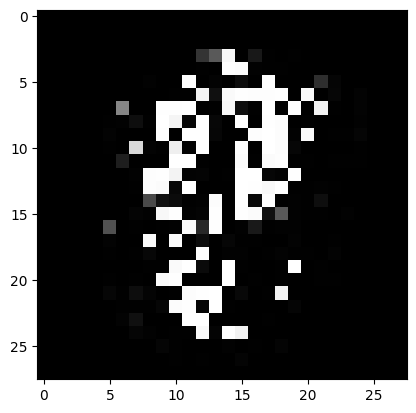

Epoch: 14550
loss_g: 2.690169095993042 	loss_d: 0.1963905692100525
Epoch: 14600
loss_g: 2.3435709476470947 	loss_d: 0.23632463812828064
Epoch: 14650
loss_g: 2.2689049243927 	loss_d: 0.3293246924877167
Epoch: 14700
loss_g: 2.1697285175323486 	loss_d: 0.32293012738227844
Epoch: 14750
loss_g: 2.2072110176086426 	loss_d: 0.27722984552383423
Epoch: 14800
loss_g: 2.42275071144104 	loss_d: 0.18395796418190002
Epoch: 14850
loss_g: 2.4692938327789307 	loss_d: 0.2671236991882324
Epoch: 14900
loss_g: 2.4494829177856445 	loss_d: 0.21393558382987976
Epoch: 14950
loss_g: 2.594616413116455 	loss_d: 0.29334548115730286
Epoch: 15000
loss_g: 2.7516684532165527 	loss_d: 0.19862845540046692


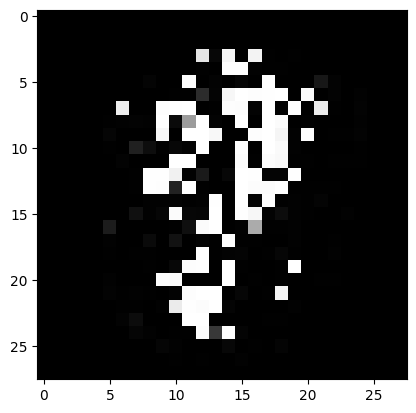

Epoch: 15050
loss_g: 2.684457302093506 	loss_d: 0.2530827820301056
Epoch: 15100
loss_g: 2.5218160152435303 	loss_d: 0.231261745095253
Epoch: 15150
loss_g: 2.4916043281555176 	loss_d: 0.31455713510513306
Epoch: 15200
loss_g: 2.0974721908569336 	loss_d: 0.38230231404304504
Epoch: 15250
loss_g: 2.2169504165649414 	loss_d: 0.1924830973148346
Epoch: 15300
loss_g: 2.370371103286743 	loss_d: 0.2041572630405426
Epoch: 15350
loss_g: 2.453357696533203 	loss_d: 0.28285548090934753
Epoch: 15400
loss_g: 2.244811773300171 	loss_d: 0.2704453468322754
Epoch: 15450
loss_g: 2.267561435699463 	loss_d: 0.269917368888855
Epoch: 15500
loss_g: 2.297046184539795 	loss_d: 0.3395839333534241


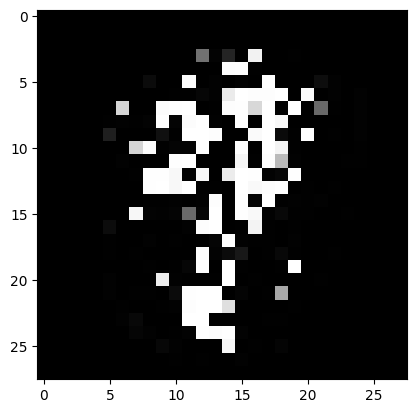

Epoch: 15550
loss_g: 2.454929828643799 	loss_d: 0.3479434847831726
Epoch: 15600
loss_g: 2.5328192710876465 	loss_d: 0.19856327772140503
Epoch: 15650
loss_g: 2.520625352859497 	loss_d: 0.22756744921207428
Epoch: 15700
loss_g: 2.083239793777466 	loss_d: 0.24501432478427887
Epoch: 15750
loss_g: 2.181877613067627 	loss_d: 0.27886155247688293
Epoch: 15800
loss_g: 2.305846929550171 	loss_d: 0.28951820731163025
Epoch: 15850
loss_g: 2.275503396987915 	loss_d: 0.2768353223800659
Epoch: 15900
loss_g: 2.3623640537261963 	loss_d: 0.21886062622070312
Epoch: 15950
loss_g: 2.3590915203094482 	loss_d: 0.2536211907863617
Epoch: 16000
loss_g: 2.361276388168335 	loss_d: 0.2353038340806961


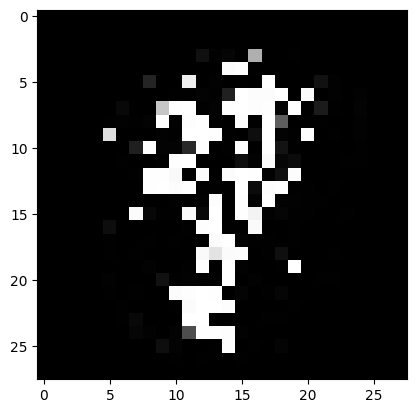

Epoch: 16050
loss_g: 2.2786102294921875 	loss_d: 0.33118459582328796
Epoch: 16100
loss_g: 2.3483223915100098 	loss_d: 0.2026037573814392
Epoch: 16150
loss_g: 2.37716007232666 	loss_d: 0.37584632635116577
Epoch: 16200
loss_g: 2.372257709503174 	loss_d: 0.22133761644363403
Epoch: 16250
loss_g: 2.5771727561950684 	loss_d: 0.29086029529571533
Epoch: 16300
loss_g: 2.7204973697662354 	loss_d: 0.24295128881931305
Epoch: 16350
loss_g: 2.8158044815063477 	loss_d: 0.17394587397575378
Epoch: 16400
loss_g: 2.876934766769409 	loss_d: 0.21850894391536713
Epoch: 16450
loss_g: 2.871739149093628 	loss_d: 0.285777747631073
Epoch: 16500
loss_g: 2.6185355186462402 	loss_d: 0.20423294603824615


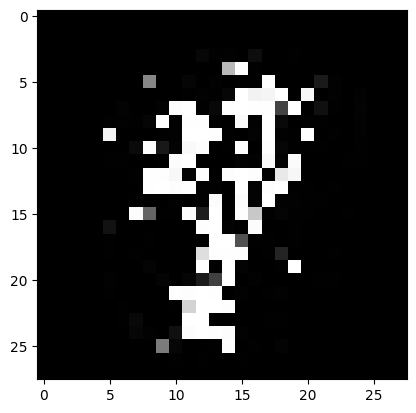

Epoch: 16550
loss_g: 1.9078365564346313 	loss_d: 0.283562034368515
Epoch: 16600
loss_g: 1.7258933782577515 	loss_d: 0.28566300868988037
Epoch: 16650
loss_g: 1.9527511596679688 	loss_d: 0.24360695481300354
Epoch: 16700
loss_g: 2.087035894393921 	loss_d: 0.2504886984825134
Epoch: 16750
loss_g: 2.175045967102051 	loss_d: 0.26611658930778503
Epoch: 16800
loss_g: 2.2602155208587646 	loss_d: 0.33982354402542114
Epoch: 16850
loss_g: 2.2664313316345215 	loss_d: 0.25468796491622925
Epoch: 16900
loss_g: 1.9752285480499268 	loss_d: 0.25735193490982056
Epoch: 16950
loss_g: 1.897511601448059 	loss_d: 0.3734132647514343
Epoch: 17000
loss_g: 2.124009132385254 	loss_d: 0.309197336435318


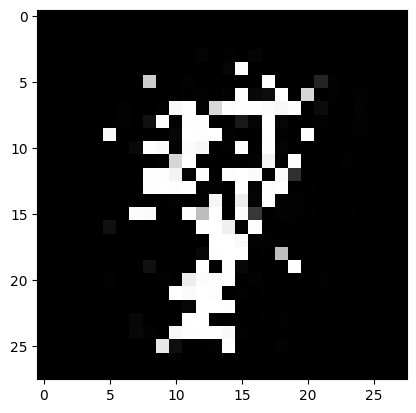

Epoch: 17050
loss_g: 2.2282471656799316 	loss_d: 0.3768889307975769
Epoch: 17100
loss_g: 2.1861801147460938 	loss_d: 0.29751741886138916
Epoch: 17150
loss_g: 2.1082873344421387 	loss_d: 0.29012876749038696
Epoch: 17200
loss_g: 1.9190744161605835 	loss_d: 0.33830446004867554
Epoch: 17250
loss_g: 1.913137435913086 	loss_d: 0.3987341523170471
Epoch: 17300
loss_g: 1.943151831626892 	loss_d: 0.2936299443244934
Epoch: 17350
loss_g: 1.9441421031951904 	loss_d: 0.5490598678588867
Epoch: 17400
loss_g: 1.9078724384307861 	loss_d: 0.39251989126205444
Epoch: 17450
loss_g: 2.013174533843994 	loss_d: 0.36761319637298584
Epoch: 17500
loss_g: 2.1775166988372803 	loss_d: 0.36288487911224365


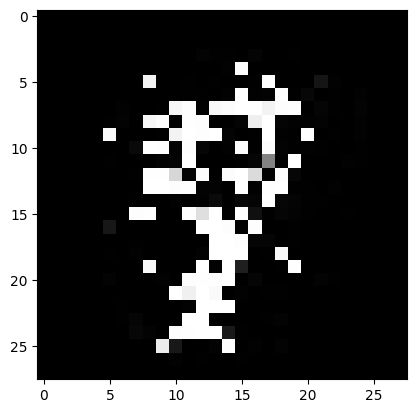

Epoch: 17550
loss_g: 2.248082399368286 	loss_d: 0.38514965772628784
Epoch: 17600
loss_g: 2.246042013168335 	loss_d: 0.45606473088264465
Epoch: 17650
loss_g: 2.301571846008301 	loss_d: 0.27677035331726074
Epoch: 17700
loss_g: 2.272969961166382 	loss_d: 0.2697814404964447
Epoch: 17750
loss_g: 2.174924373626709 	loss_d: 0.385830819606781
Epoch: 17800
loss_g: 2.2065846920013428 	loss_d: 0.3639538884162903
Epoch: 17850
loss_g: 2.2181243896484375 	loss_d: 0.3634694516658783
Epoch: 17900
loss_g: 2.2154531478881836 	loss_d: 0.35733842849731445
Epoch: 17950
loss_g: 2.2279436588287354 	loss_d: 0.39359068870544434
Epoch: 18000
loss_g: 2.0405173301696777 	loss_d: 0.27225127816200256


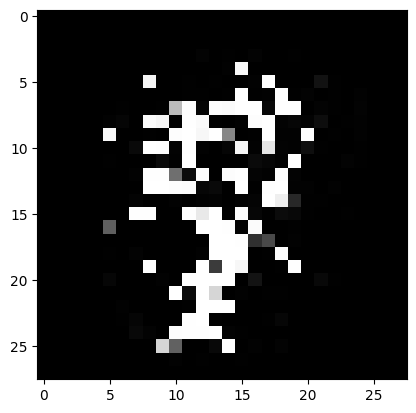

Epoch: 18050
loss_g: 1.6807851791381836 	loss_d: 0.37325936555862427
Epoch: 18100
loss_g: 1.4919365644454956 	loss_d: 0.4169759750366211
Epoch: 18150
loss_g: 1.5120928287506104 	loss_d: 0.5176095962524414
Epoch: 18200
loss_g: 1.5429619550704956 	loss_d: 0.5046841502189636
Epoch: 18250
loss_g: 1.5418411493301392 	loss_d: 0.5216358304023743
Epoch: 18300
loss_g: 1.3825151920318604 	loss_d: 0.5334052443504333
Epoch: 18350
loss_g: 1.3541518449783325 	loss_d: 0.6274484395980835
Epoch: 18400
loss_g: 1.3508208990097046 	loss_d: 0.5693143606185913
Epoch: 18450
loss_g: 1.451898455619812 	loss_d: 0.7411463260650635
Epoch: 18500
loss_g: 1.4954817295074463 	loss_d: 0.5201816558837891


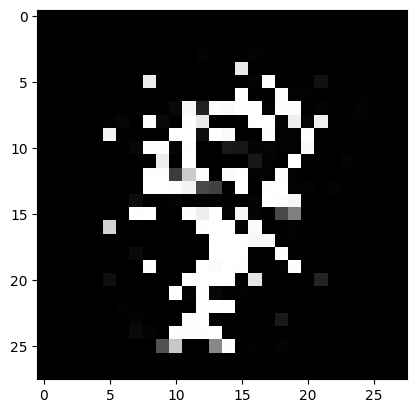

Epoch: 18550
loss_g: 1.49848473072052 	loss_d: 0.7423087358474731
Epoch: 18600
loss_g: 1.5303611755371094 	loss_d: 0.5958384275436401
Epoch: 18650
loss_g: 1.5358567237854004 	loss_d: 0.664722204208374
Epoch: 18700
loss_g: 1.4756673574447632 	loss_d: 0.6823581457138062
Epoch: 18750
loss_g: 1.3457210063934326 	loss_d: 0.6860963106155396
Epoch: 18800
loss_g: 1.1993536949157715 	loss_d: 0.8121404647827148
Epoch: 18850
loss_g: 1.2299880981445312 	loss_d: 0.8597745895385742
Epoch: 18900
loss_g: 1.3522347211837769 	loss_d: 0.7319400310516357
Epoch: 18950
loss_g: 1.491202712059021 	loss_d: 0.6622244119644165
Epoch: 19000
loss_g: 1.58050537109375 	loss_d: 0.5882452726364136


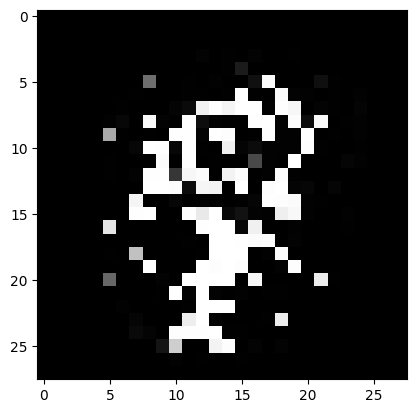

Epoch: 19050
loss_g: 1.6557965278625488 	loss_d: 0.5897853374481201
Epoch: 19100
loss_g: 1.6789144277572632 	loss_d: 0.5798662304878235
Epoch: 19150
loss_g: 1.5823317766189575 	loss_d: 0.6197670102119446
Epoch: 19200
loss_g: 1.6154812574386597 	loss_d: 0.9075359106063843
Epoch: 19250
loss_g: 1.634855031967163 	loss_d: 0.5984389781951904
Epoch: 19300
loss_g: 1.5682392120361328 	loss_d: 0.6319540143013
Epoch: 19350
loss_g: 1.403694748878479 	loss_d: 0.7821733951568604
Epoch: 19400
loss_g: 1.3147594928741455 	loss_d: 0.8215082287788391
Epoch: 19450
loss_g: 1.3814321756362915 	loss_d: 0.9676228761672974
Epoch: 19500
loss_g: 1.4879624843597412 	loss_d: 0.869672417640686


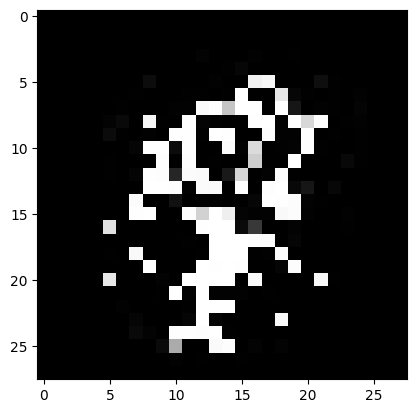

Epoch: 19550
loss_g: 1.4986525774002075 	loss_d: 0.5909788608551025
Epoch: 19600
loss_g: 1.4298244714736938 	loss_d: 0.7393181324005127
Epoch: 19650
loss_g: 1.4217809438705444 	loss_d: 0.8336767554283142
Epoch: 19700
loss_g: 1.4488379955291748 	loss_d: 0.7043284177780151
Epoch: 19750
loss_g: 1.4985946416854858 	loss_d: 1.0076075792312622
Epoch: 19800
loss_g: 1.5267044305801392 	loss_d: 0.8017537593841553
Epoch: 19850
loss_g: 1.5175564289093018 	loss_d: 0.7526924014091492
Epoch: 19900
loss_g: 1.5012643337249756 	loss_d: 0.7420634627342224
Epoch: 19950
loss_g: 1.4911994934082031 	loss_d: 0.7834818959236145
Epoch: 20000
loss_g: 1.4638947248458862 	loss_d: 0.8781965970993042


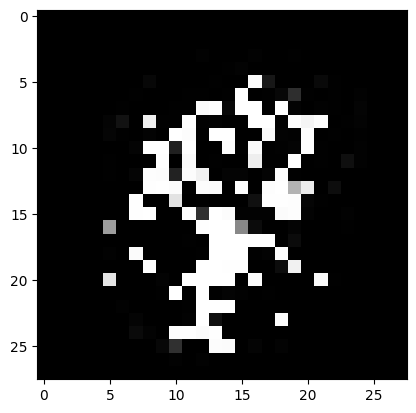

Epoch: 20050
loss_g: 1.4754796028137207 	loss_d: 0.7130088210105896
Epoch: 20100
loss_g: 1.480010747909546 	loss_d: 0.646815299987793
Epoch: 20150
loss_g: 1.4693728685379028 	loss_d: 0.8912926316261292
Epoch: 20200
loss_g: 1.405805230140686 	loss_d: 0.9308537244796753
Epoch: 20250
loss_g: 1.1977736949920654 	loss_d: 0.9613907933235168
Epoch: 20300
loss_g: 1.1531307697296143 	loss_d: 0.9071228504180908
Epoch: 20350
loss_g: 1.2019903659820557 	loss_d: 1.0559297800064087
Epoch: 20400
loss_g: 1.20025634765625 	loss_d: 0.6976140737533569
Epoch: 20450
loss_g: 1.1598643064498901 	loss_d: 0.947391152381897
Epoch: 20500
loss_g: 1.2456144094467163 	loss_d: 0.859171986579895


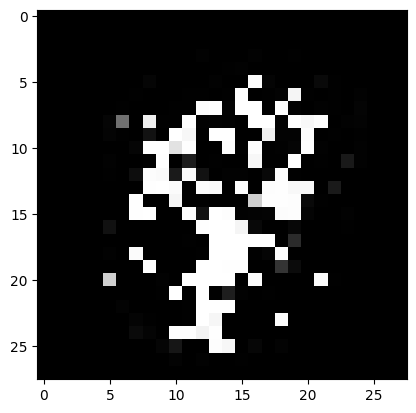

Epoch: 20550
loss_g: 1.337555170059204 	loss_d: 0.9519938230514526
Epoch: 20600
loss_g: 1.3640520572662354 	loss_d: 0.8727203011512756
Epoch: 20650
loss_g: 1.3063324689865112 	loss_d: 0.9104936122894287
Epoch: 20700
loss_g: 1.2552512884140015 	loss_d: 0.9267937541007996
Epoch: 20750
loss_g: 1.2291696071624756 	loss_d: 0.9359411597251892
Epoch: 20800
loss_g: 1.1987977027893066 	loss_d: 0.8667783737182617
Epoch: 20850
loss_g: 1.139487862586975 	loss_d: 1.1493136882781982
Epoch: 20900
loss_g: 1.0765055418014526 	loss_d: 0.8935742378234863
Epoch: 20950
loss_g: 1.0746954679489136 	loss_d: 1.1270959377288818
Epoch: 21000
loss_g: 1.107187271118164 	loss_d: 1.0036699771881104


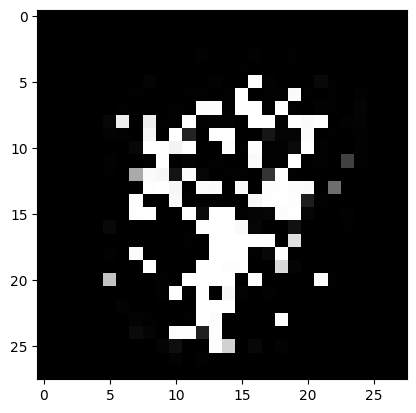

Epoch: 21050
loss_g: 1.1580673456192017 	loss_d: 1.0161070823669434
Epoch: 21100
loss_g: 1.2069735527038574 	loss_d: 1.0216106176376343
Epoch: 21150
loss_g: 1.235841989517212 	loss_d: 1.0749001502990723
Epoch: 21200
loss_g: 1.2519950866699219 	loss_d: 1.0053138732910156
Epoch: 21250
loss_g: 1.2754400968551636 	loss_d: 0.9899868965148926
Epoch: 21300
loss_g: 1.286173939704895 	loss_d: 0.9028613567352295
Epoch: 21350
loss_g: 1.299670696258545 	loss_d: 0.8365572690963745
Epoch: 21400
loss_g: 1.30086088180542 	loss_d: 0.8488200306892395
Epoch: 21450
loss_g: 1.2561745643615723 	loss_d: 0.9025655388832092
Epoch: 21500
loss_g: 1.1417831182479858 	loss_d: 0.876245379447937


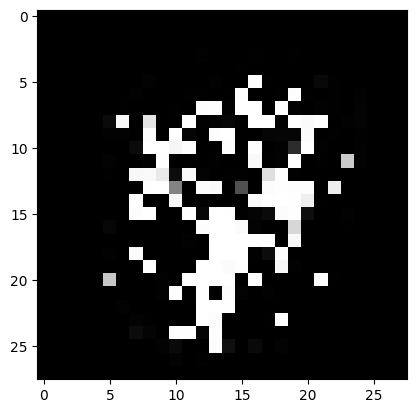

Epoch: 21550
loss_g: 1.1139769554138184 	loss_d: 0.9384618997573853
Epoch: 21600
loss_g: 1.1388388872146606 	loss_d: 1.4624149799346924
Epoch: 21650
loss_g: 1.169002652168274 	loss_d: 0.9584976434707642
Epoch: 21700
loss_g: 1.2004021406173706 	loss_d: 1.055086374282837
Epoch: 21750
loss_g: 1.222119927406311 	loss_d: 1.0078153610229492
Epoch: 21800
loss_g: 1.2339932918548584 	loss_d: 1.1141862869262695
Epoch: 21850
loss_g: 1.245120644569397 	loss_d: 1.3786628246307373
Epoch: 21900
loss_g: 1.2486664056777954 	loss_d: 1.2793290615081787
Epoch: 21950
loss_g: 1.2228477001190186 	loss_d: 0.8336504697799683
Epoch: 22000
loss_g: 1.1768332719802856 	loss_d: 1.0363795757293701


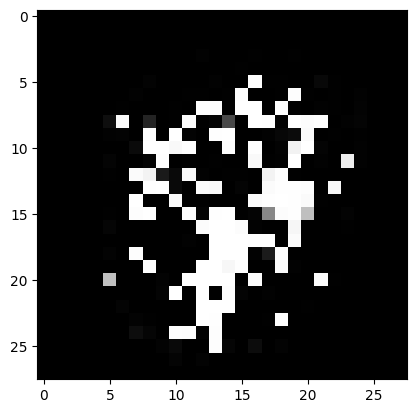

Epoch: 22050
loss_g: 1.1186293363571167 	loss_d: 1.1493443250656128
Epoch: 22100
loss_g: 1.0986295938491821 	loss_d: 1.115696668624878
Epoch: 22150
loss_g: 1.1471675634384155 	loss_d: 1.3963053226470947
Epoch: 22200
loss_g: 1.2167751789093018 	loss_d: 1.161224126815796
Epoch: 22250
loss_g: 1.283502221107483 	loss_d: 1.0585408210754395
Epoch: 22300
loss_g: 1.3420382738113403 	loss_d: 1.022755742073059
Epoch: 22350
loss_g: 1.3867225646972656 	loss_d: 1.0606939792633057
Epoch: 22400
loss_g: 1.4086554050445557 	loss_d: 1.1207222938537598
Epoch: 22450
loss_g: 1.3999801874160767 	loss_d: 0.9207069873809814
Epoch: 22500
loss_g: 1.364721655845642 	loss_d: 0.8711757659912109


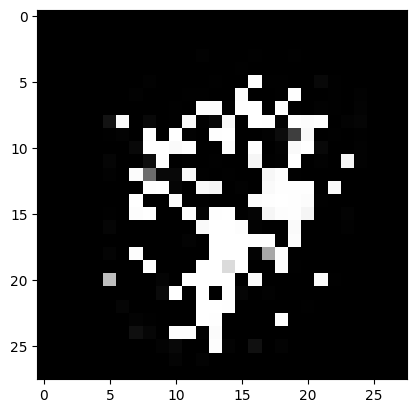

Epoch: 22550
loss_g: 1.327983021736145 	loss_d: 1.1942921876907349
Epoch: 22600
loss_g: 1.2925888299942017 	loss_d: 1.211369276046753
Epoch: 22650
loss_g: 1.2568410634994507 	loss_d: 1.141768455505371
Epoch: 22700
loss_g: 1.2210595607757568 	loss_d: 1.0486005544662476
Epoch: 22750
loss_g: 1.1957364082336426 	loss_d: 1.2504863739013672
Epoch: 22800
loss_g: 1.1446856260299683 	loss_d: 0.8760836720466614
Epoch: 22850
loss_g: 1.0558103322982788 	loss_d: 1.2210886478424072
Epoch: 22900
loss_g: 1.0092271566390991 	loss_d: 1.1821925640106201
Epoch: 22950
loss_g: 1.0244221687316895 	loss_d: 1.2613794803619385
Epoch: 23000
loss_g: 1.0648422241210938 	loss_d: 1.1698342561721802


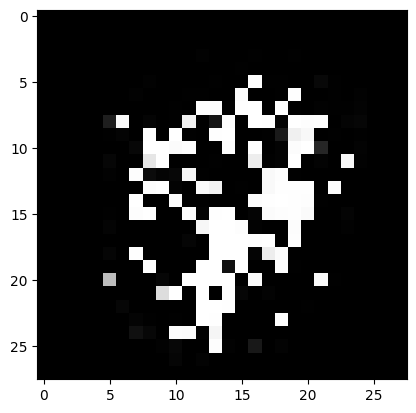

Epoch: 23050
loss_g: 1.1075228452682495 	loss_d: 1.1641383171081543
Epoch: 23100
loss_g: 1.133466362953186 	loss_d: 1.1749670505523682
Epoch: 23150
loss_g: 1.13881516456604 	loss_d: 1.1410243511199951
Epoch: 23200
loss_g: 1.1335182189941406 	loss_d: 1.0458489656448364
Epoch: 23250
loss_g: 1.1284832954406738 	loss_d: 1.333519697189331
Epoch: 23300
loss_g: 1.1155147552490234 	loss_d: 0.9852240681648254
Epoch: 23350
loss_g: 1.0760984420776367 	loss_d: 1.2281275987625122
Epoch: 23400
loss_g: 1.0053603649139404 	loss_d: 1.1785283088684082
Epoch: 23450
loss_g: 0.9388291835784912 	loss_d: 1.2463314533233643
Epoch: 23500
loss_g: 0.9111007452011108 	loss_d: 1.316599726676941


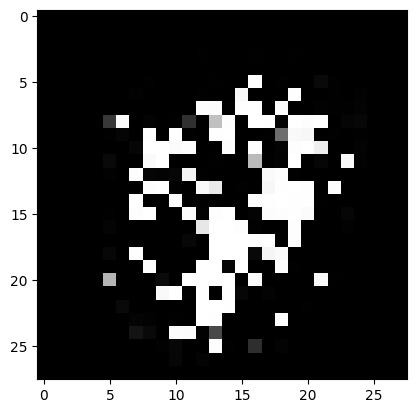

Epoch: 23550
loss_g: 0.9187698364257812 	loss_d: 1.4439198970794678
Epoch: 23600
loss_g: 0.944311797618866 	loss_d: 1.279374122619629
Epoch: 23650
loss_g: 0.9756353497505188 	loss_d: 1.2761497497558594
Epoch: 23700
loss_g: 1.0018500089645386 	loss_d: 1.1581683158874512
Epoch: 23750
loss_g: 1.0244988203048706 	loss_d: 1.0674806833267212
Epoch: 23800
loss_g: 1.0420303344726562 	loss_d: 1.099624752998352
Epoch: 23850
loss_g: 1.053970217704773 	loss_d: 1.1499872207641602
Epoch: 23900
loss_g: 1.0616534948349 	loss_d: 1.0293488502502441
Epoch: 23950
loss_g: 1.0711331367492676 	loss_d: 1.078311800956726
Epoch: 24000
loss_g: 1.0834813117980957 	loss_d: 1.7259865999221802


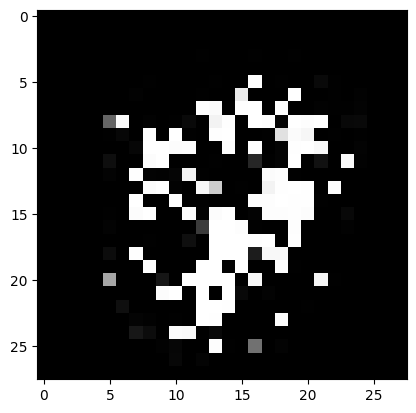

Epoch: 24050
loss_g: 1.094372272491455 	loss_d: 1.1237945556640625
Epoch: 24100
loss_g: 1.0980850458145142 	loss_d: 1.285355806350708
Epoch: 24150
loss_g: 1.088235855102539 	loss_d: 1.1870142221450806
Epoch: 24200
loss_g: 1.056545376777649 	loss_d: 1.3664367198944092
Epoch: 24250
loss_g: 1.0034658908843994 	loss_d: 1.7322487831115723
Epoch: 24300
loss_g: 0.9373365640640259 	loss_d: 1.6380844116210938
Epoch: 24350
loss_g: 0.87198805809021 	loss_d: 1.1407654285430908
Epoch: 24400
loss_g: 0.8269526362419128 	loss_d: 1.3838326930999756
Epoch: 24450
loss_g: 0.8058616518974304 	loss_d: 1.4863111972808838
Epoch: 24500
loss_g: 0.8012577891349792 	loss_d: 1.461938500404358


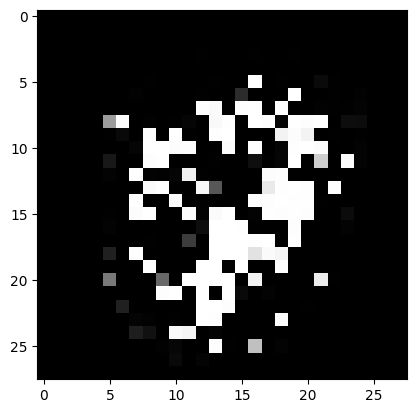

Epoch: 24550
loss_g: 0.8041378855705261 	loss_d: 1.7776634693145752
Epoch: 24600
loss_g: 0.8094712495803833 	loss_d: 1.5662717819213867
Epoch: 24650
loss_g: 0.8149646520614624 	loss_d: 1.4769304990768433
Epoch: 24700
loss_g: 0.8209269642829895 	loss_d: 1.4780428409576416
Epoch: 24750
loss_g: 0.8227285742759705 	loss_d: 1.5447977781295776
Epoch: 24800
loss_g: 0.8252184987068176 	loss_d: 1.6118403673171997
Epoch: 24850
loss_g: 0.8295986652374268 	loss_d: 1.3774869441986084
Epoch: 24900
loss_g: 0.8340489268302917 	loss_d: 1.3081356287002563
Epoch: 24950
loss_g: 0.8377467393875122 	loss_d: 1.6578128337860107
Epoch: 25000
loss_g: 0.8416438102722168 	loss_d: 1.692176103591919


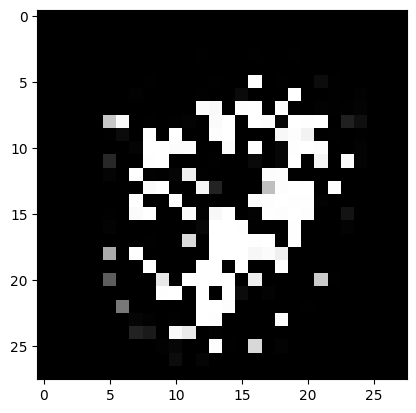

Epoch: 25050
loss_g: 0.8442466259002686 	loss_d: 1.5483450889587402
Epoch: 25100
loss_g: 0.8467031121253967 	loss_d: 1.4383764266967773
Epoch: 25150
loss_g: 0.8458266854286194 	loss_d: 1.657336950302124
Epoch: 25200
loss_g: 0.8437623977661133 	loss_d: 1.2315764427185059
Epoch: 25250
loss_g: 0.8378635048866272 	loss_d: 1.5894533395767212
Epoch: 25300
loss_g: 0.8314022421836853 	loss_d: 1.521841287612915
Epoch: 25350
loss_g: 0.8223803639411926 	loss_d: 1.5950734615325928
Epoch: 25400
loss_g: 0.8139553070068359 	loss_d: 1.5292119979858398
Epoch: 25450
loss_g: 0.8064441680908203 	loss_d: 1.5302402973175049
Epoch: 25500
loss_g: 0.7979212999343872 	loss_d: 1.58062744140625


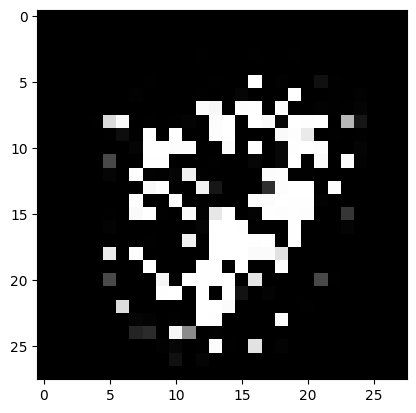

Epoch: 25550
loss_g: 0.7865871787071228 	loss_d: 1.5792109966278076
Epoch: 25600
loss_g: 0.7770207524299622 	loss_d: 1.459972620010376
Epoch: 25650
loss_g: 0.7700379490852356 	loss_d: 1.7936744689941406
Epoch: 25700
loss_g: 0.7622683644294739 	loss_d: 1.3827292919158936
Epoch: 25750
loss_g: 0.7515110373497009 	loss_d: 1.6355786323547363
Epoch: 25800
loss_g: 0.7351676225662231 	loss_d: 1.5836855173110962
Epoch: 25850
loss_g: 0.7173500061035156 	loss_d: 1.5965479612350464
Epoch: 25900
loss_g: 0.7036808133125305 	loss_d: 1.7040667533874512
Epoch: 25950
loss_g: 0.6972509622573853 	loss_d: 1.8682591915130615
Epoch: 26000
loss_g: 0.6981931924819946 	loss_d: 1.6316505670547485


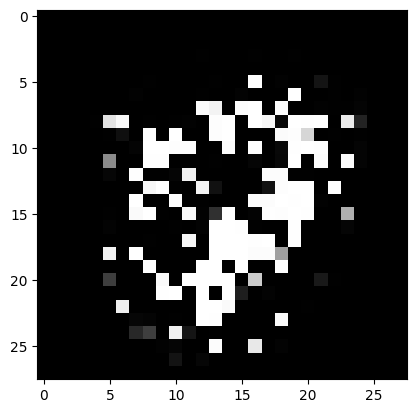

Epoch: 26050
loss_g: 0.7022886276245117 	loss_d: 1.6885591745376587
Epoch: 26100
loss_g: 0.7089123129844666 	loss_d: 1.5512354373931885
Epoch: 26150
loss_g: 0.7163622975349426 	loss_d: 1.4507102966308594
Epoch: 26200
loss_g: 0.7245010137557983 	loss_d: 1.4906413555145264
Epoch: 26250
loss_g: 0.732518196105957 	loss_d: 1.567317247390747
Epoch: 26300
loss_g: 0.7405222654342651 	loss_d: 1.418623924255371
Epoch: 26350
loss_g: 0.748072624206543 	loss_d: 1.458171010017395
Epoch: 26400
loss_g: 0.7543858289718628 	loss_d: 2.2169995307922363
Epoch: 26450
loss_g: 0.760701596736908 	loss_d: 1.5164780616760254
Epoch: 26500
loss_g: 0.764624297618866 	loss_d: 1.729624629020691


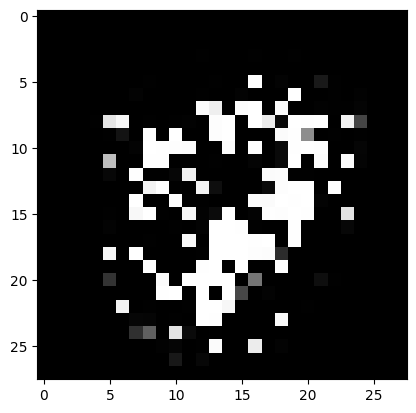

Epoch: 26550
loss_g: 0.7686471343040466 	loss_d: 1.5873647928237915
Epoch: 26600
loss_g: 0.770900309085846 	loss_d: 1.7814693450927734
Epoch: 26650
loss_g: 0.7693837285041809 	loss_d: 2.1651406288146973
Epoch: 26700
loss_g: 0.7662745714187622 	loss_d: 2.0097885131835938
Epoch: 26750
loss_g: 0.7606120109558105 	loss_d: 1.3786563873291016
Epoch: 26800
loss_g: 0.7523794174194336 	loss_d: 1.641002893447876
Epoch: 26850
loss_g: 0.7396910190582275 	loss_d: 1.7376552820205688
Epoch: 26900
loss_g: 0.7199558019638062 	loss_d: 1.7071609497070312
Epoch: 26950
loss_g: 0.698424220085144 	loss_d: 2.0809497833251953
Epoch: 27000
loss_g: 0.6765035390853882 	loss_d: 1.8702325820922852


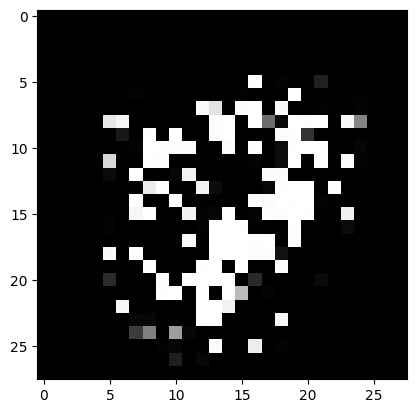

Epoch: 27050
loss_g: 0.6590069532394409 	loss_d: 1.7907066345214844
Epoch: 27100
loss_g: 0.6478341817855835 	loss_d: 1.830603837966919
Epoch: 27150
loss_g: 0.6411886215209961 	loss_d: 1.9147131443023682
Epoch: 27200
loss_g: 0.6384143233299255 	loss_d: 1.974448800086975
Epoch: 27250
loss_g: 0.6387102603912354 	loss_d: 1.7113996744155884
Epoch: 27300
loss_g: 0.6419913172721863 	loss_d: 1.629220962524414
Epoch: 27350
loss_g: 0.6449188590049744 	loss_d: 2.007976770401001
Epoch: 27400
loss_g: 0.6499786972999573 	loss_d: 2.057933807373047
Epoch: 27450
loss_g: 0.6544857621192932 	loss_d: 1.857359766960144
Epoch: 27500
loss_g: 0.6601153612136841 	loss_d: 1.7530878782272339


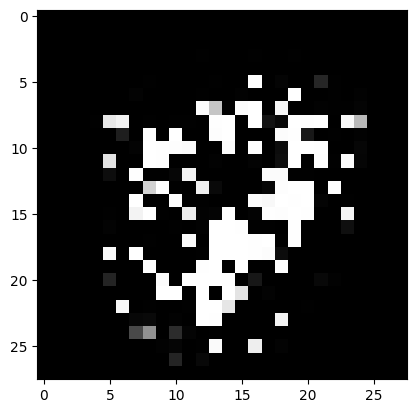

Epoch: 27550
loss_g: 0.6639914512634277 	loss_d: 1.9671874046325684
Epoch: 27600
loss_g: 0.6677222847938538 	loss_d: 1.5323271751403809
Epoch: 27650
loss_g: 0.6703523397445679 	loss_d: 1.9052602052688599
Epoch: 27700
loss_g: 0.6716769337654114 	loss_d: 1.8316283226013184
Epoch: 27750
loss_g: 0.6712849140167236 	loss_d: 1.8868541717529297
Epoch: 27800
loss_g: 0.6693557500839233 	loss_d: 1.8042800426483154
Epoch: 27850
loss_g: 0.66574627161026 	loss_d: 1.7901101112365723
Epoch: 27900
loss_g: 0.6593969464302063 	loss_d: 1.8517556190490723
Epoch: 27950
loss_g: 0.6490705609321594 	loss_d: 1.865523099899292
Epoch: 28000
loss_g: 0.639154851436615 	loss_d: 1.7216918468475342


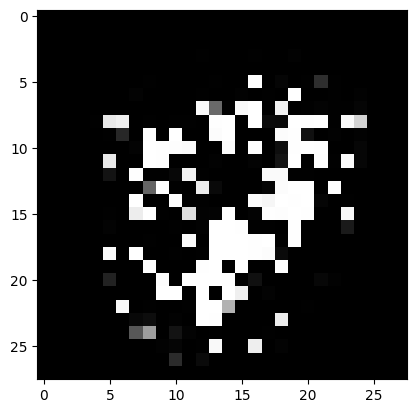

Epoch: 28050
loss_g: 0.6286070942878723 	loss_d: 2.087531805038452
Epoch: 28100
loss_g: 0.6195542216300964 	loss_d: 1.6367096900939941
Epoch: 28150
loss_g: 0.6107162237167358 	loss_d: 1.9036366939544678
Epoch: 28200
loss_g: 0.6033012866973877 	loss_d: 1.8624415397644043
Epoch: 28250
loss_g: 0.5971897840499878 	loss_d: 1.8357009887695312
Epoch: 28300
loss_g: 0.5921080112457275 	loss_d: 1.9650945663452148
Epoch: 28350
loss_g: 0.5875583291053772 	loss_d: 2.1416854858398438
Epoch: 28400
loss_g: 0.5829723477363586 	loss_d: 1.8567206859588623
Epoch: 28450
loss_g: 0.5778253674507141 	loss_d: 1.95528244972229
Epoch: 28500
loss_g: 0.5732475519180298 	loss_d: 1.8115460872650146


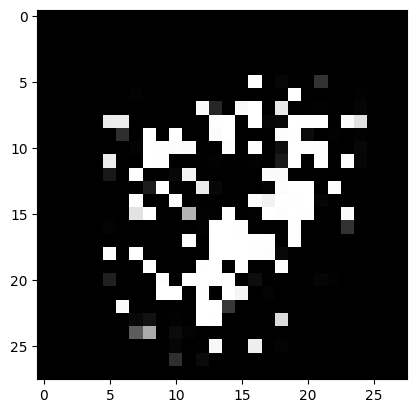

Epoch: 28550
loss_g: 0.5689654350280762 	loss_d: 1.7146787643432617
Epoch: 28600
loss_g: 0.5649511218070984 	loss_d: 1.76670503616333
Epoch: 28650
loss_g: 0.55875164270401 	loss_d: 1.8706094026565552
Epoch: 28700
loss_g: 0.5510804653167725 	loss_d: 1.7302963733673096
Epoch: 28750
loss_g: 0.5438747406005859 	loss_d: 1.7742714881896973
Epoch: 28800
loss_g: 0.5361399054527283 	loss_d: 2.604301929473877
Epoch: 28850
loss_g: 0.5282773375511169 	loss_d: 1.8685834407806396
Epoch: 28900
loss_g: 0.5198984146118164 	loss_d: 2.1225247383117676
Epoch: 28950
loss_g: 0.5112011432647705 	loss_d: 1.9845153093338013
Epoch: 29000
loss_g: 0.5028810501098633 	loss_d: 2.207704544067383


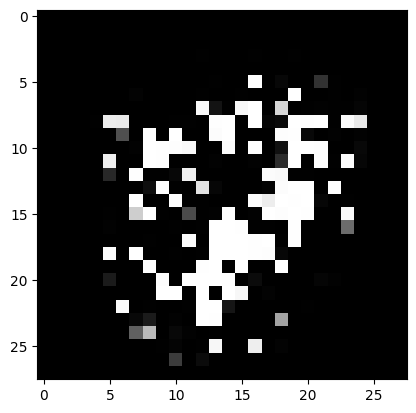

Epoch: 29050
loss_g: 0.49380385875701904 	loss_d: 2.613582134246826
Epoch: 29100
loss_g: 0.48536649346351624 	loss_d: 2.46035099029541
Epoch: 29150
loss_g: 0.47613492608070374 	loss_d: 1.8004322052001953
Epoch: 29200
loss_g: 0.4663769006729126 	loss_d: 2.095278263092041
Epoch: 29250
loss_g: 0.4559295177459717 	loss_d: 2.197810649871826
Epoch: 29300
loss_g: 0.4462878406047821 	loss_d: 2.152280807495117
Epoch: 29350
loss_g: 0.43634146451950073 	loss_d: 2.5407419204711914
Epoch: 29400
loss_g: 0.42601048946380615 	loss_d: 2.3130593299865723
Epoch: 29450
loss_g: 0.4166852533817291 	loss_d: 2.232785224914551
Epoch: 29500
loss_g: 0.4070419669151306 	loss_d: 2.290642261505127


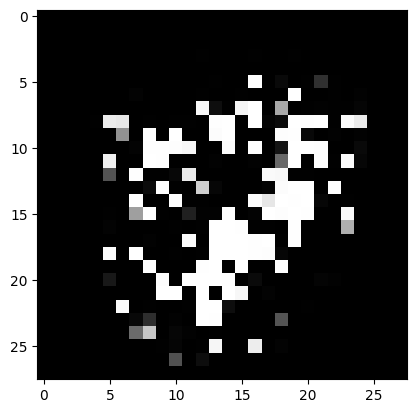

Epoch: 29550
loss_g: 0.3978061079978943 	loss_d: 2.3888301849365234
Epoch: 29600
loss_g: 0.38842177391052246 	loss_d: 2.4589970111846924
Epoch: 29650
loss_g: 0.37948527932167053 	loss_d: 2.1975972652435303
Epoch: 29700
loss_g: 0.37107303738594055 	loss_d: 2.1308209896087646
Epoch: 29750
loss_g: 0.36275145411491394 	loss_d: 2.5463433265686035
Epoch: 29800
loss_g: 0.355076402425766 	loss_d: 2.630375623703003
Epoch: 29850
loss_g: 0.3481582701206207 	loss_d: 2.42314076423645
Epoch: 29900
loss_g: 0.3416181802749634 	loss_d: 2.3488101959228516
Epoch: 29950
loss_g: 0.3355250358581543 	loss_d: 2.5804336071014404
Epoch: 30000
loss_g: 0.32991793751716614 	loss_d: 2.1653261184692383


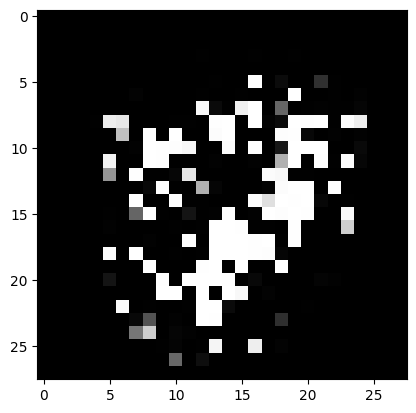

Epoch: 30050
loss_g: 0.3245604932308197 	loss_d: 2.562161684036255
Epoch: 30100
loss_g: 0.3195708692073822 	loss_d: 2.5070087909698486
Epoch: 30150
loss_g: 0.3151337504386902 	loss_d: 2.5668468475341797
Epoch: 30200
loss_g: 0.3108396530151367 	loss_d: 2.4863758087158203
Epoch: 30250
loss_g: 0.30734628438949585 	loss_d: 2.474107027053833
Epoch: 30300
loss_g: 0.30379676818847656 	loss_d: 2.5455753803253174
Epoch: 30350
loss_g: 0.3004046678543091 	loss_d: 2.565725326538086
Epoch: 30400
loss_g: 0.29798561334609985 	loss_d: 2.4002208709716797
Epoch: 30450
loss_g: 0.29547858238220215 	loss_d: 2.780944347381592
Epoch: 30500
loss_g: 0.2927977740764618 	loss_d: 2.299574375152588


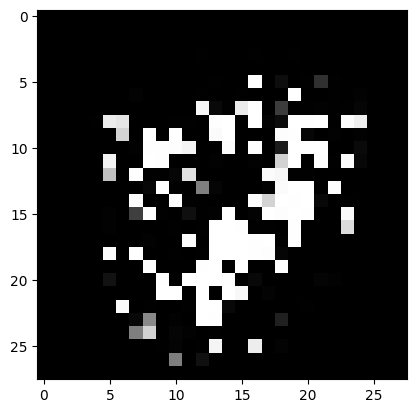

Epoch: 30550
loss_g: 0.29065677523612976 	loss_d: 2.571108341217041
Epoch: 30600
loss_g: 0.28873196244239807 	loss_d: 2.5385470390319824
Epoch: 30650
loss_g: 0.28693029284477234 	loss_d: 2.4894449710845947
Epoch: 30700
loss_g: 0.2848895490169525 	loss_d: 2.6363143920898438
Epoch: 30750
loss_g: 0.28341495990753174 	loss_d: 2.8220722675323486
Epoch: 30800
loss_g: 0.28213199973106384 	loss_d: 2.5050063133239746
Epoch: 30850
loss_g: 0.28073665499687195 	loss_d: 2.6160740852355957
Epoch: 30900
loss_g: 0.2795131206512451 	loss_d: 2.463189125061035
Epoch: 30950
loss_g: 0.27863937616348267 	loss_d: 2.356511354446411
Epoch: 31000
loss_g: 0.27761411666870117 	loss_d: 2.408675193786621


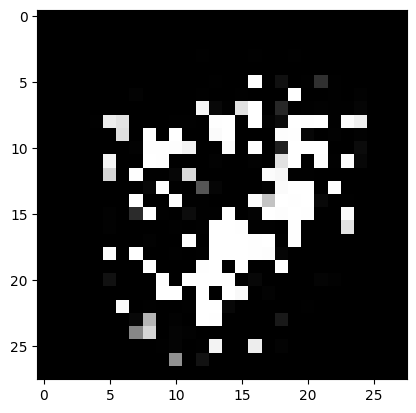

Epoch: 31050
loss_g: 0.2766736149787903 	loss_d: 2.514050006866455
Epoch: 31100
loss_g: 0.2755582630634308 	loss_d: 2.3613650798797607
Epoch: 31150
loss_g: 0.27481943368911743 	loss_d: 2.388770580291748
Epoch: 31200
loss_g: 0.2741463780403137 	loss_d: 3.247514247894287
Epoch: 31250
loss_g: 0.2733292281627655 	loss_d: 2.469520092010498
Epoch: 31300
loss_g: 0.2723727822303772 	loss_d: 2.7278332710266113
Epoch: 31350
loss_g: 0.27152907848358154 	loss_d: 2.576023578643799
Epoch: 31400
loss_g: 0.2704537808895111 	loss_d: 2.794208526611328
Epoch: 31450
loss_g: 0.2693651020526886 	loss_d: 3.196340560913086
Epoch: 31500
loss_g: 0.268592894077301 	loss_d: 3.0290796756744385


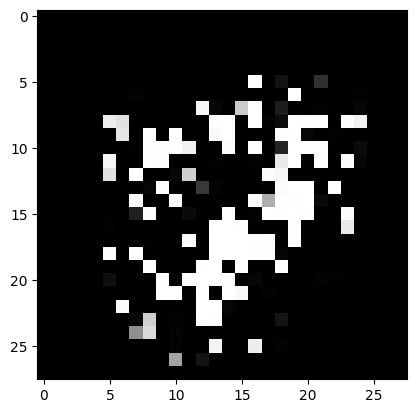

Epoch: 31550
loss_g: 0.2672657072544098 	loss_d: 2.331465244293213
Epoch: 31600
loss_g: 0.26567283272743225 	loss_d: 2.631258249282837
Epoch: 31650
loss_g: 0.26429039239883423 	loss_d: 2.72267484664917
Epoch: 31700
loss_g: 0.26263242959976196 	loss_d: 2.6537203788757324
Epoch: 31750
loss_g: 0.2609499990940094 	loss_d: 3.044083595275879
Epoch: 31800
loss_g: 0.2591245472431183 	loss_d: 2.7939345836639404
Epoch: 31850
loss_g: 0.2569470703601837 	loss_d: 2.7024459838867188
Epoch: 31900
loss_g: 0.2553038001060486 	loss_d: 2.751549243927002
Epoch: 31950
loss_g: 0.2529827356338501 	loss_d: 2.8402740955352783
Epoch: 32000
loss_g: 0.2511689066886902 	loss_d: 2.8960142135620117


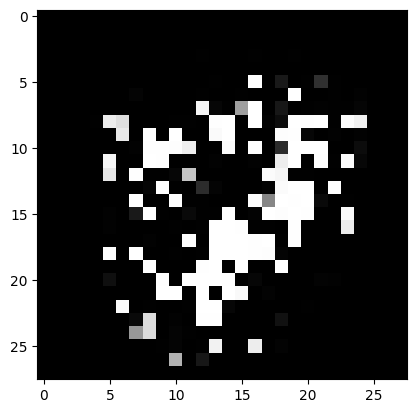

Epoch: 32050
loss_g: 0.24878260493278503 	loss_d: 2.6123898029327393
Epoch: 32100
loss_g: 0.2463318556547165 	loss_d: 2.5317540168762207
Epoch: 32150
loss_g: 0.243992879986763 	loss_d: 2.9466304779052734
Epoch: 32200
loss_g: 0.24206511676311493 	loss_d: 3.0237746238708496
Epoch: 32250
loss_g: 0.2396342009305954 	loss_d: 2.791616439819336
Epoch: 32300
loss_g: 0.23770327866077423 	loss_d: 2.7159786224365234
Epoch: 32350
loss_g: 0.23534877598285675 	loss_d: 2.9347641468048096
Epoch: 32400
loss_g: 0.23322947323322296 	loss_d: 2.5142619609832764
Epoch: 32450
loss_g: 0.2318257987499237 	loss_d: 2.9092350006103516
Epoch: 32500
loss_g: 0.22976922988891602 	loss_d: 2.849381446838379


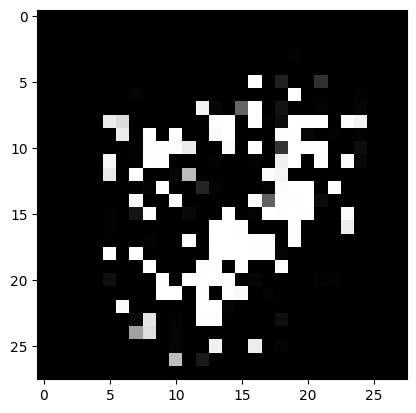

Epoch: 32550
loss_g: 0.22822676599025726 	loss_d: 2.9020233154296875
Epoch: 32600
loss_g: 0.22640658915042877 	loss_d: 2.8111801147460938
Epoch: 32650
loss_g: 0.22509951889514923 	loss_d: 2.7908132076263428
Epoch: 32700
loss_g: 0.2236073762178421 	loss_d: 2.860581398010254
Epoch: 32750
loss_g: 0.22218596935272217 	loss_d: 2.8831748962402344
Epoch: 32800
loss_g: 0.22096988558769226 	loss_d: 2.7056467533111572
Epoch: 32850
loss_g: 0.21945378184318542 	loss_d: 3.0918960571289062
Epoch: 32900
loss_g: 0.2183166891336441 	loss_d: 2.5926403999328613
Epoch: 32950
loss_g: 0.2174670547246933 	loss_d: 2.867281436920166
Epoch: 33000
loss_g: 0.21658286452293396 	loss_d: 2.836289644241333


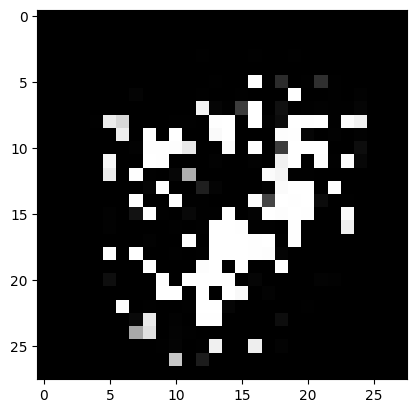

Epoch: 33050
loss_g: 0.2154211550951004 	loss_d: 2.7746682167053223
Epoch: 33100
loss_g: 0.21452933549880981 	loss_d: 2.929028272628784
Epoch: 33150
loss_g: 0.213850200176239 	loss_d: 3.1190128326416016
Epoch: 33200
loss_g: 0.2128061056137085 	loss_d: 2.785336494445801
Epoch: 33250
loss_g: 0.21221648156642914 	loss_d: 2.9037604331970215
Epoch: 33300
loss_g: 0.21150225400924683 	loss_d: 2.746359348297119
Epoch: 33350
loss_g: 0.2106107920408249 	loss_d: 2.634690999984741
Epoch: 33400
loss_g: 0.2099182903766632 	loss_d: 2.6880993843078613
Epoch: 33450
loss_g: 0.20906642079353333 	loss_d: 2.7981338500976562
Epoch: 33500
loss_g: 0.208419069647789 	loss_d: 2.641587972640991


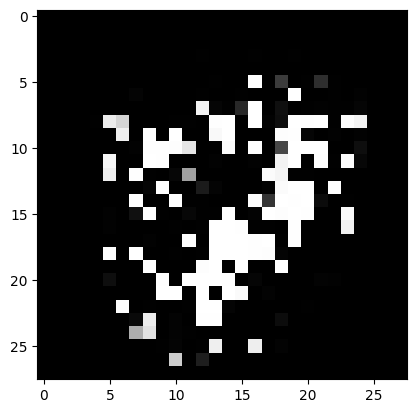

Epoch: 33550
loss_g: 0.20759569108486176 	loss_d: 2.665578842163086
Epoch: 33600
loss_g: 0.2065616399049759 	loss_d: 3.5414419174194336
Epoch: 33650
loss_g: 0.2058195322751999 	loss_d: 2.7507739067077637
Epoch: 33700
loss_g: 0.20489272475242615 	loss_d: 3.016484260559082
Epoch: 33750
loss_g: 0.20416492223739624 	loss_d: 2.8621020317077637
Epoch: 33800
loss_g: 0.20304082334041595 	loss_d: 3.0842032432556152
Epoch: 33850
loss_g: 0.20219604671001434 	loss_d: 3.488818645477295
Epoch: 33900
loss_g: 0.20159313082695007 	loss_d: 3.321079730987549
Epoch: 33950
loss_g: 0.20061247050762177 	loss_d: 2.6121060848236084
Epoch: 34000
loss_g: 0.19989432394504547 	loss_d: 2.9166996479034424


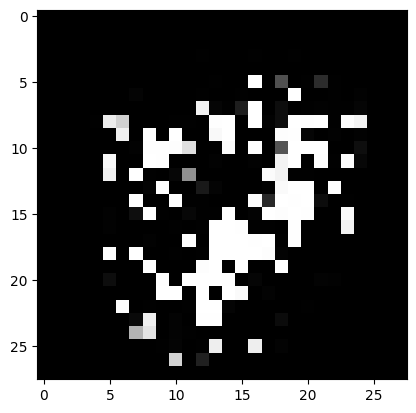

Epoch: 34050
loss_g: 0.19899789988994598 	loss_d: 3.006800651550293
Epoch: 34100
loss_g: 0.19790270924568176 	loss_d: 2.932544469833374
Epoch: 34150
loss_g: 0.1969234198331833 	loss_d: 3.3256592750549316
Epoch: 34200
loss_g: 0.19602340459823608 	loss_d: 3.0693507194519043
Epoch: 34250
loss_g: 0.1952047348022461 	loss_d: 2.9748706817626953
Epoch: 34300
loss_g: 0.1943262368440628 	loss_d: 3.0240445137023926
Epoch: 34350
loss_g: 0.19320185482501984 	loss_d: 3.1109395027160645
Epoch: 34400
loss_g: 0.19240516424179077 	loss_d: 3.160351514816284
Epoch: 34450
loss_g: 0.1916477233171463 	loss_d: 2.8701024055480957
Epoch: 34500
loss_g: 0.19048479199409485 	loss_d: 2.785390615463257


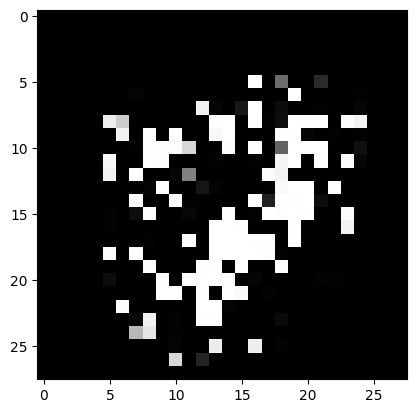

Epoch: 34550
loss_g: 0.18935498595237732 	loss_d: 3.2003111839294434
Epoch: 34600
loss_g: 0.18856677412986755 	loss_d: 3.2776331901550293
Epoch: 34650
loss_g: 0.18730933964252472 	loss_d: 3.0341033935546875
Epoch: 34700
loss_g: 0.18612559139728546 	loss_d: 2.957874298095703
Epoch: 34750
loss_g: 0.1855570375919342 	loss_d: 3.1714415550231934
Epoch: 34800
loss_g: 0.18455371260643005 	loss_d: 2.7496612071990967
Epoch: 34850
loss_g: 0.18357788026332855 	loss_d: 3.1429381370544434
Epoch: 34900
loss_g: 0.18245215713977814 	loss_d: 3.082770824432373
Epoch: 34950
loss_g: 0.18161456286907196 	loss_d: 3.1323461532592773
Epoch: 35000
loss_g: 0.18038566410541534 	loss_d: 3.035360336303711


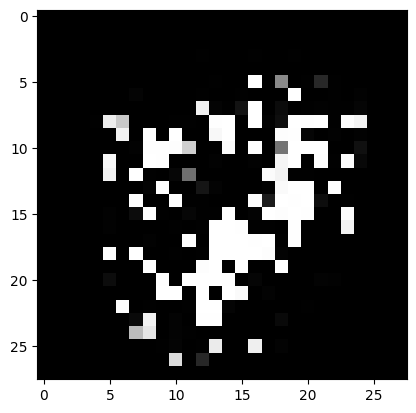

Epoch: 35050
loss_g: 0.17950427532196045 	loss_d: 3.013491630554199
Epoch: 35100
loss_g: 0.178758904337883 	loss_d: 3.0854783058166504
Epoch: 35150
loss_g: 0.17759454250335693 	loss_d: 3.1079087257385254
Epoch: 35200
loss_g: 0.17661641538143158 	loss_d: 2.9248738288879395
Epoch: 35250
loss_g: 0.1759534776210785 	loss_d: 3.3169684410095215
Epoch: 35300
loss_g: 0.1748284101486206 	loss_d: 2.811612129211426
Epoch: 35350
loss_g: 0.17379558086395264 	loss_d: 3.086709499359131
Epoch: 35400
loss_g: 0.17329345643520355 	loss_d: 3.058014154434204
Epoch: 35450
loss_g: 0.17235906422138214 	loss_d: 2.9931368827819824
Epoch: 35500
loss_g: 0.17155173420906067 	loss_d: 3.152836799621582


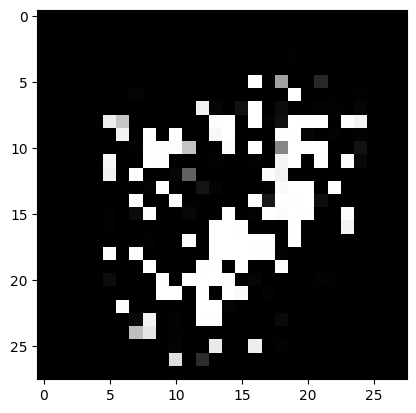

Epoch: 35550
loss_g: 0.17035552859306335 	loss_d: 3.3435492515563965
Epoch: 35600
loss_g: 0.16973808407783508 	loss_d: 3.0056328773498535
Epoch: 35650
loss_g: 0.16914546489715576 	loss_d: 3.1285157203674316
Epoch: 35700
loss_g: 0.16825859248638153 	loss_d: 2.9701437950134277
Epoch: 35750
loss_g: 0.1674048751592636 	loss_d: 2.85794734954834
Epoch: 35800
loss_g: 0.1667085587978363 	loss_d: 2.914034366607666
Epoch: 35850
loss_g: 0.16592702269554138 	loss_d: 3.0262808799743652
Epoch: 35900
loss_g: 0.1650519073009491 	loss_d: 2.8672282695770264
Epoch: 35950
loss_g: 0.16456924378871918 	loss_d: 2.8914453983306885
Epoch: 36000
loss_g: 0.16370490193367004 	loss_d: 3.775811195373535


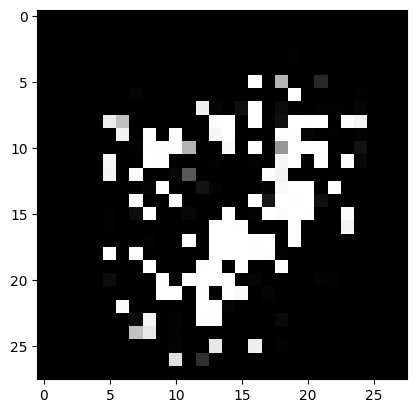

Epoch: 36050
loss_g: 0.16272374987602234 	loss_d: 2.9771728515625
Epoch: 36100
loss_g: 0.16234397888183594 	loss_d: 3.2471139430999756
Epoch: 36150
loss_g: 0.16142676770687103 	loss_d: 3.0937561988830566
Epoch: 36200
loss_g: 0.1607014387845993 	loss_d: 3.315110683441162
Epoch: 36250
loss_g: 0.16010096669197083 	loss_d: 3.720459461212158
Epoch: 36300
loss_g: 0.15937413275241852 	loss_d: 3.5522212982177734
Epoch: 36350
loss_g: 0.1584816575050354 	loss_d: 2.8376479148864746
Epoch: 36400
loss_g: 0.15791940689086914 	loss_d: 3.1471853256225586
Epoch: 36450
loss_g: 0.15708307921886444 	loss_d: 3.236800193786621
Epoch: 36500
loss_g: 0.15654055774211884 	loss_d: 3.159043312072754


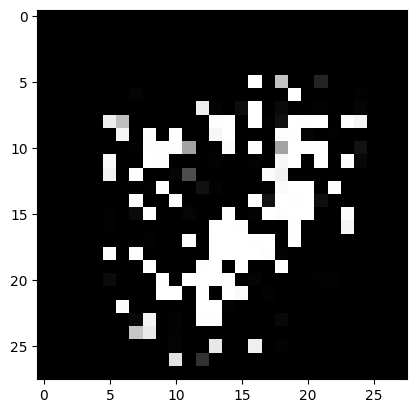

Epoch: 36550
loss_g: 0.15604035556316376 	loss_d: 3.5550246238708496
Epoch: 36600
loss_g: 0.15519514679908752 	loss_d: 3.297297477722168
Epoch: 36650
loss_g: 0.15419194102287292 	loss_d: 3.204507350921631
Epoch: 36700
loss_g: 0.1533397138118744 	loss_d: 3.2545061111450195
Epoch: 36750
loss_g: 0.15255066752433777 	loss_d: 3.3418667316436768
Epoch: 36800
loss_g: 0.15173207223415375 	loss_d: 3.39264178276062
Epoch: 36850
loss_g: 0.15115076303482056 	loss_d: 3.099835157394409
Epoch: 36900
loss_g: 0.15035377442836761 	loss_d: 3.0147955417633057
Epoch: 36950
loss_g: 0.14950759708881378 	loss_d: 3.4311814308166504
Epoch: 37000
loss_g: 0.14883258938789368 	loss_d: 3.5080056190490723


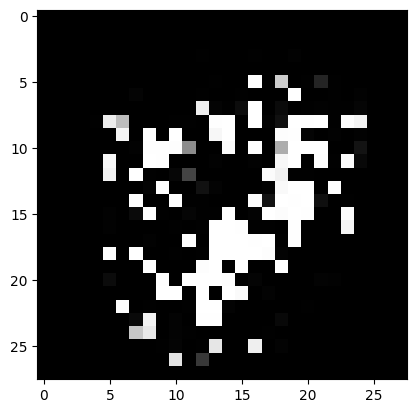

Epoch: 37050
loss_g: 0.147875115275383 	loss_d: 3.259444236755371
Epoch: 37100
loss_g: 0.14747154712677002 	loss_d: 3.185349464416504
Epoch: 37150
loss_g: 0.14658810198307037 	loss_d: 3.396162986755371
Epoch: 37200
loss_g: 0.14589281380176544 	loss_d: 2.974635124206543
Epoch: 37250
loss_g: 0.145120769739151 	loss_d: 3.369485378265381
Epoch: 37300
loss_g: 0.14454568922519684 	loss_d: 3.3080151081085205
Epoch: 37350
loss_g: 0.14366860687732697 	loss_d: 3.3562583923339844
Epoch: 37400
loss_g: 0.1430131047964096 	loss_d: 3.2577433586120605
Epoch: 37450
loss_g: 0.14241893589496613 	loss_d: 3.2362914085388184
Epoch: 37500
loss_g: 0.14182676374912262 	loss_d: 3.3058528900146484


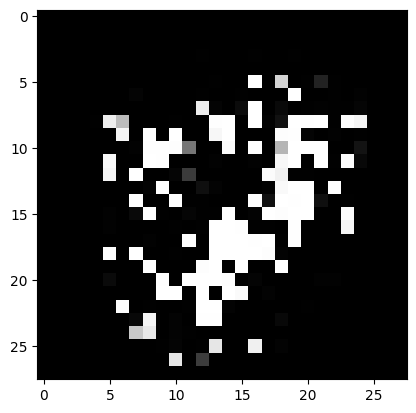

Epoch: 37550
loss_g: 0.14120563864707947 	loss_d: 3.3300111293792725
Epoch: 37600
loss_g: 0.14052323997020721 	loss_d: 3.1437575817108154
Epoch: 37650
loss_g: 0.13986088335514069 	loss_d: 3.536510467529297
Epoch: 37700
loss_g: 0.13933585584163666 	loss_d: 3.028172254562378
Epoch: 37750
loss_g: 0.1388319432735443 	loss_d: 3.304899215698242
Epoch: 37800
loss_g: 0.13811084628105164 	loss_d: 3.275785446166992
Epoch: 37850
loss_g: 0.1374431699514389 	loss_d: 3.209524631500244
Epoch: 37900
loss_g: 0.1368265450000763 	loss_d: 3.369525194168091
Epoch: 37950
loss_g: 0.1362866908311844 	loss_d: 3.562134265899658
Epoch: 38000
loss_g: 0.13556228578090668 	loss_d: 3.2195229530334473


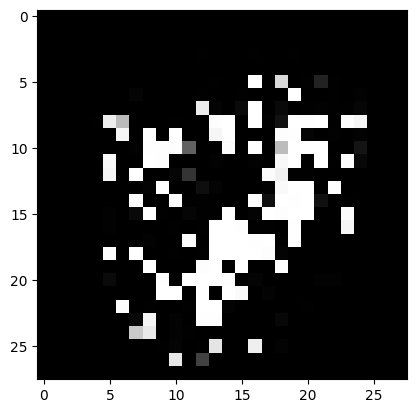

Epoch: 38050
loss_g: 0.13512079417705536 	loss_d: 3.343985080718994
Epoch: 38100
loss_g: 0.1343647688627243 	loss_d: 3.1830873489379883
Epoch: 38150
loss_g: 0.1338857263326645 	loss_d: 3.070894718170166
Epoch: 38200
loss_g: 0.1333419233560562 	loss_d: 3.1265435218811035
Epoch: 38250
loss_g: 0.13283886015415192 	loss_d: 3.239262580871582
Epoch: 38300
loss_g: 0.1324409693479538 	loss_d: 3.0784287452697754
Epoch: 38350
loss_g: 0.1317862868309021 	loss_d: 3.1022236347198486
Epoch: 38400
loss_g: 0.1310681253671646 	loss_d: 3.988445281982422
Epoch: 38450
loss_g: 0.13082769513130188 	loss_d: 3.186079978942871
Epoch: 38500
loss_g: 0.13029985129833221 	loss_d: 3.454592704772949


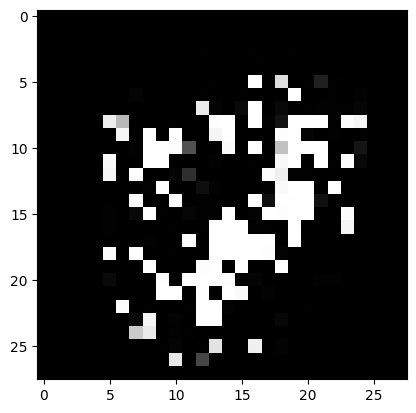

Epoch: 38550
loss_g: 0.12982489168643951 	loss_d: 3.301401138305664
Epoch: 38600
loss_g: 0.12931188941001892 	loss_d: 3.520869255065918
Epoch: 38650
loss_g: 0.12894746661186218 	loss_d: 3.9279651641845703
Epoch: 38700
loss_g: 0.12829728424549103 	loss_d: 3.7578377723693848
Epoch: 38750
loss_g: 0.12801772356033325 	loss_d: 3.0413706302642822
Epoch: 38800
loss_g: 0.1276208758354187 	loss_d: 3.3492255210876465
Epoch: 38850
loss_g: 0.12712129950523376 	loss_d: 3.439505100250244
Epoch: 38900
loss_g: 0.12678663432598114 	loss_d: 3.3596243858337402
Epoch: 38950
loss_g: 0.12635448575019836 	loss_d: 3.75581955909729
Epoch: 39000
loss_g: 0.12592899799346924 	loss_d: 3.4956018924713135


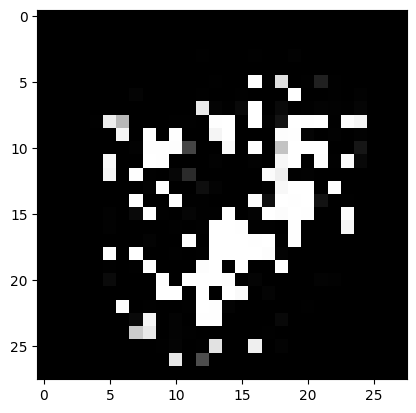

Epoch: 39050
loss_g: 0.12559974193572998 	loss_d: 3.39998722076416
Epoch: 39100
loss_g: 0.1252686083316803 	loss_d: 3.447742462158203
Epoch: 39150
loss_g: 0.12469272315502167 	loss_d: 3.5327703952789307
Epoch: 39200
loss_g: 0.12443408370018005 	loss_d: 3.5817108154296875
Epoch: 39250
loss_g: 0.12408675998449326 	loss_d: 3.2860941886901855
Epoch: 39300
loss_g: 0.12381327152252197 	loss_d: 3.2000813484191895
Epoch: 39350
loss_g: 0.12362124770879745 	loss_d: 3.6136550903320312
Epoch: 39400
loss_g: 0.12293137609958649 	loss_d: 3.6876330375671387
Epoch: 39450
loss_g: 0.1227177232503891 	loss_d: 3.4388198852539062
Epoch: 39500
loss_g: 0.1222400814294815 	loss_d: 3.36226224899292


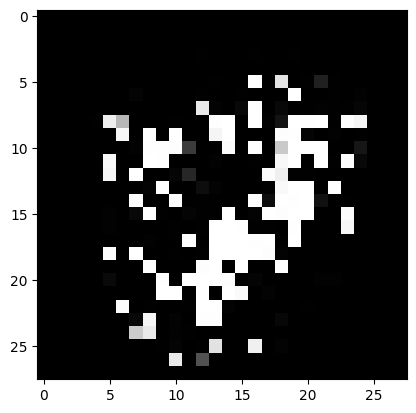

Epoch: 39550
loss_g: 0.12205501645803452 	loss_d: 3.5721912384033203
Epoch: 39600
loss_g: 0.12159523367881775 	loss_d: 3.146578073501587
Epoch: 39650
loss_g: 0.12142837047576904 	loss_d: 3.538869857788086
Epoch: 39700
loss_g: 0.12104202061891556 	loss_d: 3.4766366481781006
Epoch: 39750
loss_g: 0.1207498237490654 	loss_d: 3.5215985774993896
Epoch: 39800
loss_g: 0.1205500066280365 	loss_d: 3.4227514266967773
Epoch: 39850
loss_g: 0.12034793943166733 	loss_d: 3.3991310596466064
Epoch: 39900
loss_g: 0.11987745016813278 	loss_d: 3.4659600257873535
Epoch: 39950
loss_g: 0.11975304037332535 	loss_d: 3.487523317337036
Epoch: 40000
loss_g: 0.11929982900619507 	loss_d: 3.2993154525756836


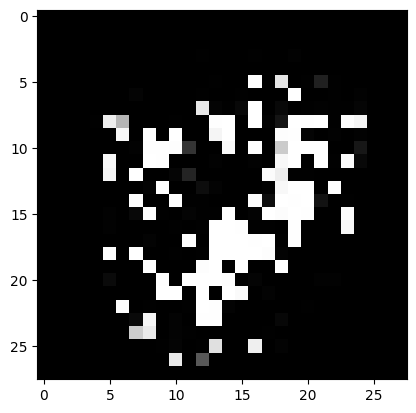

Epoch: 40050
loss_g: 0.119087353348732 	loss_d: 3.6918795108795166
Epoch: 40100
loss_g: 0.11891894787549973 	loss_d: 3.181018114089966
Epoch: 40150
loss_g: 0.11855382472276688 	loss_d: 3.4546289443969727
Epoch: 40200
loss_g: 0.11824540793895721 	loss_d: 3.42437481880188
Epoch: 40250
loss_g: 0.1179126426577568 	loss_d: 3.354616165161133
Epoch: 40300
loss_g: 0.11781571805477142 	loss_d: 3.5131936073303223
Epoch: 40350
loss_g: 0.11745042353868484 	loss_d: 3.7030863761901855
Epoch: 40400
loss_g: 0.11723709106445312 	loss_d: 3.3586668968200684
Epoch: 40450
loss_g: 0.11677511036396027 	loss_d: 3.4814066886901855
Epoch: 40500
loss_g: 0.1165638118982315 	loss_d: 3.320059061050415


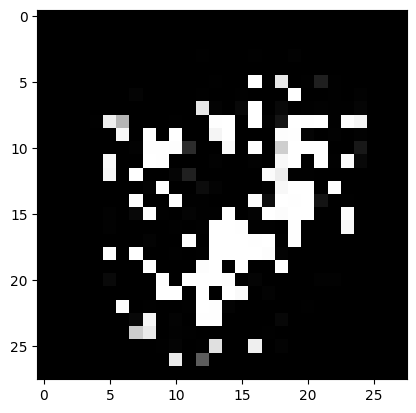

Epoch: 40550
loss_g: 0.11630947142839432 	loss_d: 3.2059006690979004
Epoch: 40600
loss_g: 0.1160576120018959 	loss_d: 3.2590346336364746
Epoch: 40650
loss_g: 0.11571620404720306 	loss_d: 3.368112087249756
Epoch: 40700
loss_g: 0.11541244387626648 	loss_d: 3.2081546783447266
Epoch: 40750
loss_g: 0.11512010544538498 	loss_d: 3.2297658920288086
Epoch: 40800
loss_g: 0.11501104384660721 	loss_d: 4.113470077514648
Epoch: 40850
loss_g: 0.11472836136817932 	loss_d: 3.309807538986206
Epoch: 40900
loss_g: 0.11447610706090927 	loss_d: 3.577913761138916
Epoch: 40950
loss_g: 0.11427226662635803 	loss_d: 3.4222841262817383
Epoch: 41000
loss_g: 0.11406590789556503 	loss_d: 3.6408536434173584


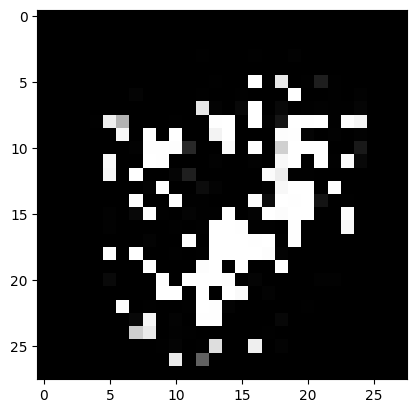

Epoch: 41050
loss_g: 0.11386865377426147 	loss_d: 4.044793128967285
Epoch: 41100
loss_g: 0.11360986530780792 	loss_d: 3.874418258666992
Epoch: 41150
loss_g: 0.11333005875349045 	loss_d: 3.1567018032073975
Epoch: 41200
loss_g: 0.1131875291466713 	loss_d: 3.4645915031433105
Epoch: 41250
loss_g: 0.11303187906742096 	loss_d: 3.552777051925659
Epoch: 41300
loss_g: 0.112681083381176 	loss_d: 3.471339702606201
Epoch: 41350
loss_g: 0.1125335767865181 	loss_d: 3.86696720123291
Epoch: 41400
loss_g: 0.11225170642137527 	loss_d: 3.6037025451660156
Epoch: 41450
loss_g: 0.11208021640777588 	loss_d: 3.5096311569213867
Epoch: 41500
loss_g: 0.111968494951725 	loss_d: 3.5549607276916504


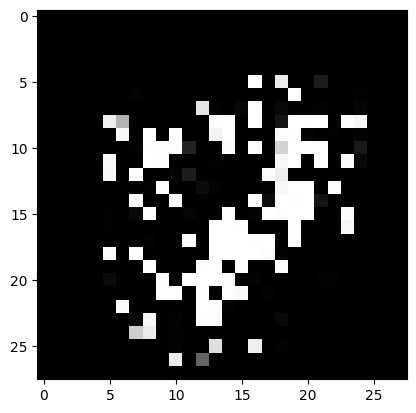

Epoch: 41550
loss_g: 0.11164989322423935 	loss_d: 3.6395273208618164
Epoch: 41600
loss_g: 0.11150173097848892 	loss_d: 3.6864829063415527
Epoch: 41650
loss_g: 0.11130629479885101 	loss_d: 3.390859365463257
Epoch: 41700
loss_g: 0.11107798665761948 	loss_d: 3.3002452850341797
Epoch: 41750
loss_g: 0.11094892024993896 	loss_d: 3.7154541015625
Epoch: 41800
loss_g: 0.11086013913154602 	loss_d: 3.7879350185394287
Epoch: 41850
loss_g: 0.11062055081129074 	loss_d: 3.5363082885742188
Epoch: 41900
loss_g: 0.11035197228193283 	loss_d: 3.4606094360351562
Epoch: 41950
loss_g: 0.11020500212907791 	loss_d: 3.6675937175750732
Epoch: 42000
loss_g: 0.10997680574655533 	loss_d: 3.242255687713623


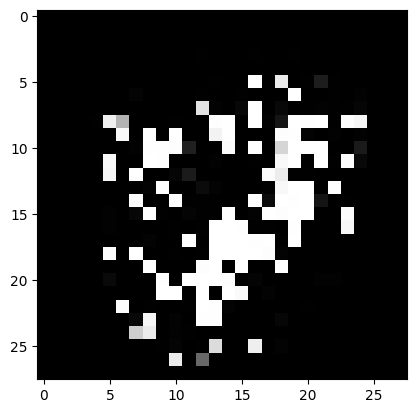

Epoch: 42050
loss_g: 0.10987589508295059 	loss_d: 3.635499954223633
Epoch: 42100
loss_g: 0.10977944731712341 	loss_d: 3.570465087890625
Epoch: 42150
loss_g: 0.10947921872138977 	loss_d: 3.6145238876342773
Epoch: 42200
loss_g: 0.10927797108888626 	loss_d: 3.514835834503174
Epoch: 42250
loss_g: 0.10918764770030975 	loss_d: 3.4886598587036133
Epoch: 42300
loss_g: 0.10896619409322739 	loss_d: 3.557682514190674
Epoch: 42350
loss_g: 0.10890338569879532 	loss_d: 3.57773494720459
Epoch: 42400
loss_g: 0.10853172093629837 	loss_d: 3.3892409801483154
Epoch: 42450
loss_g: 0.10846319049596786 	loss_d: 3.7805423736572266
Epoch: 42500
loss_g: 0.10827548801898956 	loss_d: 3.2679548263549805


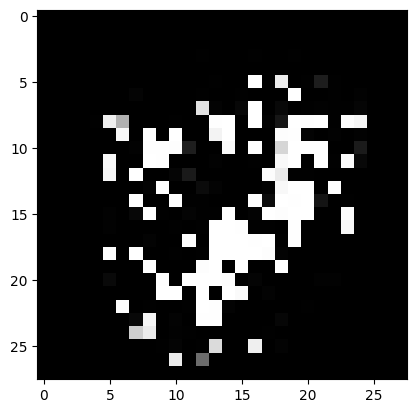

Epoch: 42550
loss_g: 0.10832183808088303 	loss_d: 3.5421390533447266
Epoch: 42600
loss_g: 0.10790131241083145 	loss_d: 3.509615898132324
Epoch: 42650
loss_g: 0.10785860568284988 	loss_d: 3.4398305416107178
Epoch: 42700
loss_g: 0.10781362652778625 	loss_d: 3.5974347591400146
Epoch: 42750
loss_g: 0.10743019729852676 	loss_d: 3.7867047786712646
Epoch: 42800
loss_g: 0.10729707777500153 	loss_d: 3.4412050247192383
Epoch: 42850
loss_g: 0.10716947168111801 	loss_d: 3.5619494915008545
Epoch: 42900
loss_g: 0.1070455014705658 	loss_d: 3.3992762565612793
Epoch: 42950
loss_g: 0.10691694915294647 	loss_d: 3.2842226028442383
Epoch: 43000
loss_g: 0.10674083232879639 	loss_d: 3.337010383605957


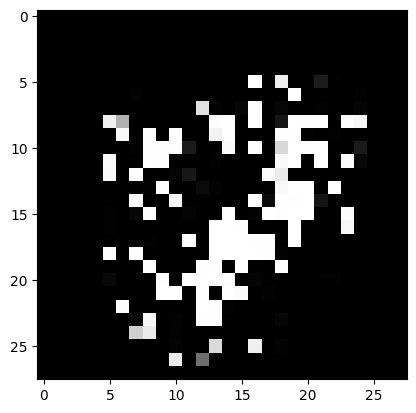

Epoch: 43050
loss_g: 0.10674358159303665 	loss_d: 3.4464330673217773
Epoch: 43100
loss_g: 0.10639459639787674 	loss_d: 3.2858598232269287
Epoch: 43150
loss_g: 0.10644916445016861 	loss_d: 3.304388999938965
Epoch: 43200
loss_g: 0.1062779501080513 	loss_d: 4.188699722290039
Epoch: 43250
loss_g: 0.10598821192979813 	loss_d: 3.38497257232666
Epoch: 43300
loss_g: 0.10594423115253448 	loss_d: 3.6506786346435547
Epoch: 43350
loss_g: 0.10579849779605865 	loss_d: 3.494319200515747
Epoch: 43400
loss_g: 0.10569815337657928 	loss_d: 3.713662624359131
Epoch: 43450
loss_g: 0.10563190281391144 	loss_d: 4.116143703460693
Epoch: 43500
loss_g: 0.10540276020765305 	loss_d: 3.9454574584960938


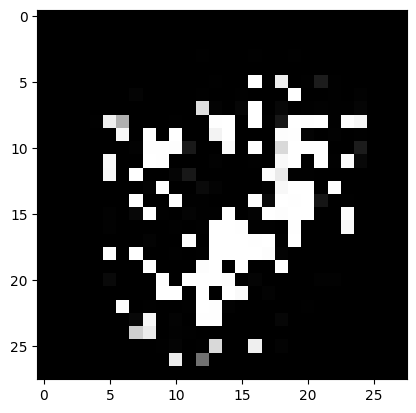

Epoch: 43550
loss_g: 0.10533510893583298 	loss_d: 3.2259361743927
Epoch: 43600
loss_g: 0.10507383197546005 	loss_d: 3.5336697101593018
Epoch: 43650
loss_g: 0.10487917065620422 	loss_d: 3.6200220584869385
Epoch: 43700
loss_g: 0.10487357527017593 	loss_d: 3.5385050773620605
Epoch: 43750
loss_g: 0.10482190549373627 	loss_d: 3.934391498565674
Epoch: 43800
loss_g: 0.10462592542171478 	loss_d: 3.6709952354431152
Epoch: 43850
loss_g: 0.10459178686141968 	loss_d: 3.5742855072021484
Epoch: 43900
loss_g: 0.10429158806800842 	loss_d: 3.6212897300720215
Epoch: 43950
loss_g: 0.10425073653459549 	loss_d: 3.704371452331543
Epoch: 44000
loss_g: 0.1041795164346695 	loss_d: 3.7515501976013184


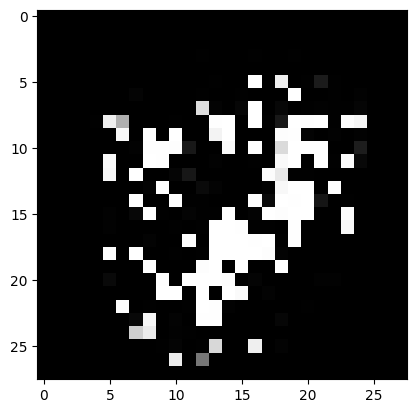

Epoch: 44050
loss_g: 0.10400548577308655 	loss_d: 3.4533982276916504
Epoch: 44100
loss_g: 0.10395602881908417 	loss_d: 3.3636255264282227
Epoch: 44150
loss_g: 0.10371886938810349 	loss_d: 3.778865098953247
Epoch: 44200
loss_g: 0.10372205823659897 	loss_d: 3.852492332458496
Epoch: 44250
loss_g: 0.10351373255252838 	loss_d: 3.598426342010498
Epoch: 44300
loss_g: 0.1035054549574852 	loss_d: 3.5212717056274414
Epoch: 44350
loss_g: 0.10342694073915482 	loss_d: 3.7290291786193848
Epoch: 44400
loss_g: 0.10316470265388489 	loss_d: 3.3037047386169434
Epoch: 44450
loss_g: 0.10300641506910324 	loss_d: 3.69534969329834
Epoch: 44500
loss_g: 0.103016696870327 	loss_d: 3.630281925201416


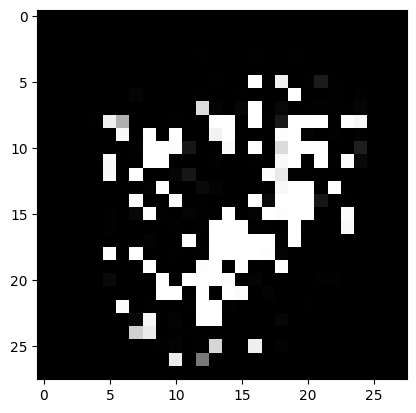

Epoch: 44550
loss_g: 0.10291782021522522 	loss_d: 3.67453670501709
Epoch: 44600
loss_g: 0.10280327498912811 	loss_d: 3.573207378387451
Epoch: 44650
loss_g: 0.10273648798465729 	loss_d: 3.547551155090332
Epoch: 44700
loss_g: 0.10256702452898026 	loss_d: 3.6140828132629395
Epoch: 44750
loss_g: 0.10232167690992355 	loss_d: 3.6353931427001953
Epoch: 44800
loss_g: 0.10233103483915329 	loss_d: 3.4454565048217773
Epoch: 44850
loss_g: 0.10221178084611893 	loss_d: 3.83542537689209
Epoch: 44900
loss_g: 0.10202384740114212 	loss_d: 3.3228578567504883
Epoch: 44950
loss_g: 0.10201271623373032 	loss_d: 3.597153902053833
Epoch: 45000
loss_g: 0.10188712924718857 	loss_d: 3.5655665397644043


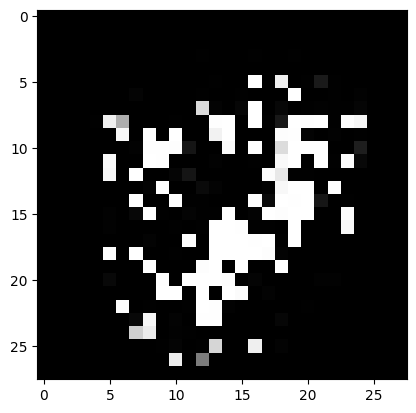

Epoch: 45050
loss_g: 0.10174531489610672 	loss_d: 3.493889570236206
Epoch: 45100
loss_g: 0.10167745500802994 	loss_d: 3.6513538360595703
Epoch: 45150
loss_g: 0.10154378414154053 	loss_d: 3.840928316116333
Epoch: 45200
loss_g: 0.10152653604745865 	loss_d: 3.4952640533447266
Epoch: 45250
loss_g: 0.10142241418361664 	loss_d: 3.6162071228027344
Epoch: 45300
loss_g: 0.1013590469956398 	loss_d: 3.453784942626953
Epoch: 45350
loss_g: 0.10105498880147934 	loss_d: 3.3376331329345703
Epoch: 45400
loss_g: 0.10110166668891907 	loss_d: 3.3903985023498535
Epoch: 45450
loss_g: 0.1009729653596878 	loss_d: 3.498192071914673
Epoch: 45500
loss_g: 0.10086248070001602 	loss_d: 3.3377914428710938


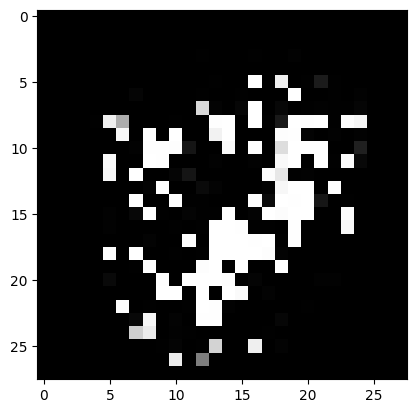

Epoch: 45550
loss_g: 0.10083382576704025 	loss_d: 3.357374429702759
Epoch: 45600
loss_g: 0.10050632059574127 	loss_d: 4.23969841003418
Epoch: 45650
loss_g: 0.1004677340388298 	loss_d: 3.4356706142425537
Epoch: 45700
loss_g: 0.10054898262023926 	loss_d: 3.7020912170410156
Epoch: 45750
loss_g: 0.10042697936296463 	loss_d: 3.544527530670166
Epoch: 45800
loss_g: 0.10021352767944336 	loss_d: 3.763662338256836
Epoch: 45850
loss_g: 0.1002325639128685 	loss_d: 4.166441917419434
Epoch: 45900
loss_g: 0.10010597109794617 	loss_d: 3.993983268737793
Epoch: 45950
loss_g: 0.09999493509531021 	loss_d: 3.274786949157715
Epoch: 46000
loss_g: 0.09987972676753998 	loss_d: 3.582613468170166


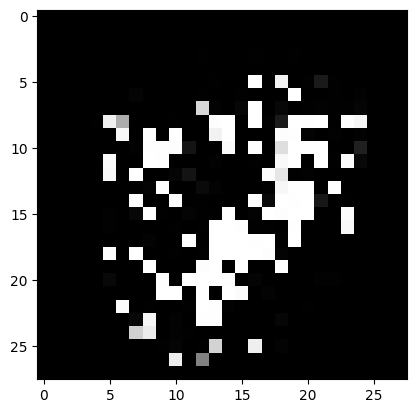

Epoch: 46050
loss_g: 0.09986042976379395 	loss_d: 3.6689329147338867
Epoch: 46100
loss_g: 0.09961479157209396 	loss_d: 3.586638927459717
Epoch: 46150
loss_g: 0.09961734712123871 	loss_d: 3.9816370010375977
Epoch: 46200
loss_g: 0.09958813339471817 	loss_d: 3.718559503555298
Epoch: 46250
loss_g: 0.09949371963739395 	loss_d: 3.622434616088867
Epoch: 46300
loss_g: 0.09931109100580215 	loss_d: 3.6681461334228516
Epoch: 46350
loss_g: 0.09929198026657104 	loss_d: 3.7517337799072266
Epoch: 46400
loss_g: 0.09913938492536545 	loss_d: 3.7993922233581543
Epoch: 46450
loss_g: 0.09893526136875153 	loss_d: 3.5002875328063965
Epoch: 46500
loss_g: 0.09898398816585541 	loss_d: 3.410478115081787


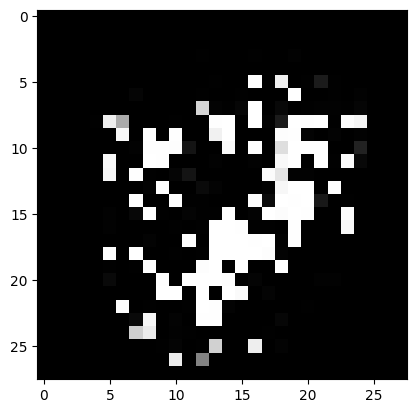

Epoch: 46550
loss_g: 0.09885591268539429 	loss_d: 3.823939085006714
Epoch: 46600
loss_g: 0.09878478944301605 	loss_d: 3.8958027362823486
Epoch: 46650
loss_g: 0.09880023449659348 	loss_d: 3.644015312194824
Epoch: 46700
loss_g: 0.09859996289014816 	loss_d: 3.566408634185791
Epoch: 46750
loss_g: 0.09846518933773041 	loss_d: 3.7738308906555176
Epoch: 46800
loss_g: 0.09840134531259537 	loss_d: 3.3485805988311768
Epoch: 46850
loss_g: 0.09831435978412628 	loss_d: 3.739287853240967
Epoch: 46900
loss_g: 0.09828004986047745 	loss_d: 3.6747641563415527
Epoch: 46950
loss_g: 0.0982537791132927 	loss_d: 3.718496322631836
Epoch: 47000
loss_g: 0.09811379015445709 	loss_d: 3.6163759231567383


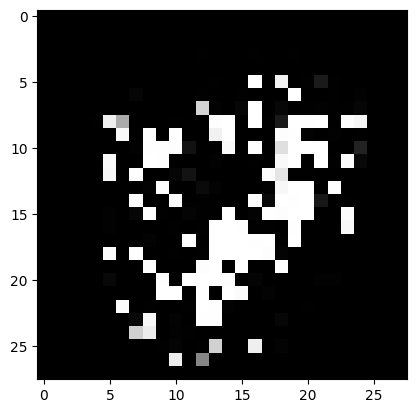

Epoch: 47050
loss_g: 0.09804191440343857 	loss_d: 3.591043710708618
Epoch: 47100
loss_g: 0.09790315479040146 	loss_d: 3.6568682193756104
Epoch: 47150
loss_g: 0.09785064309835434 	loss_d: 3.6781749725341797
Epoch: 47200
loss_g: 0.09779661893844604 	loss_d: 3.4881601333618164
Epoch: 47250
loss_g: 0.09767671674489975 	loss_d: 3.8791794776916504
Epoch: 47300
loss_g: 0.09773930162191391 	loss_d: 3.365780830383301
Epoch: 47350
loss_g: 0.09746963530778885 	loss_d: 3.638141632080078
Epoch: 47400
loss_g: 0.09748714417219162 	loss_d: 3.607599973678589
Epoch: 47450
loss_g: 0.09745992720127106 	loss_d: 3.5357308387756348
Epoch: 47500
loss_g: 0.09728061407804489 	loss_d: 3.692779541015625


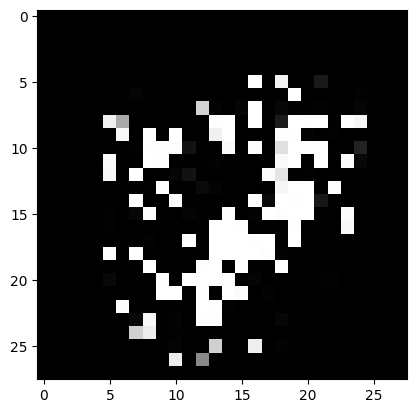

Epoch: 47550
loss_g: 0.09732481837272644 	loss_d: 3.8823723793029785
Epoch: 47600
loss_g: 0.09720844775438309 	loss_d: 3.5350632667541504
Epoch: 47650
loss_g: 0.09717870503664017 	loss_d: 3.6572747230529785
Epoch: 47700
loss_g: 0.09707073122262955 	loss_d: 3.493523359298706
Epoch: 47750
loss_g: 0.09698493033647537 	loss_d: 3.3779501914978027
Epoch: 47800
loss_g: 0.09690789133310318 	loss_d: 3.4293389320373535
Epoch: 47850
loss_g: 0.09680439531803131 	loss_d: 3.5397329330444336
Epoch: 47900
loss_g: 0.09671047329902649 	loss_d: 3.376654624938965
Epoch: 47950
loss_g: 0.09658688306808472 	loss_d: 3.3960061073303223
Epoch: 48000
loss_g: 0.09646504372358322 	loss_d: 4.278872489929199


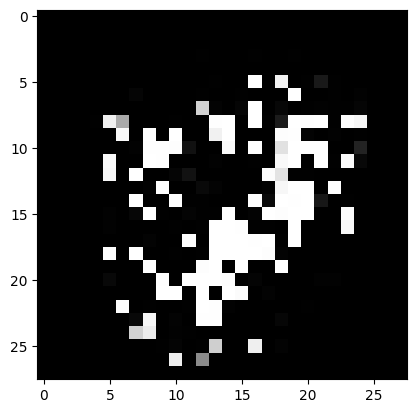

Epoch: 48050
loss_g: 0.09641822427511215 	loss_d: 3.4751358032226562
Epoch: 48100
loss_g: 0.09632709622383118 	loss_d: 3.7421441078186035
Epoch: 48150
loss_g: 0.09636195749044418 	loss_d: 3.5835518836975098
Epoch: 48200
loss_g: 0.09626705199480057 	loss_d: 3.803039312362671
Epoch: 48250
loss_g: 0.0961885154247284 	loss_d: 4.204996109008789
Epoch: 48300
loss_g: 0.09623609483242035 	loss_d: 4.033041000366211
Epoch: 48350
loss_g: 0.09607541561126709 	loss_d: 3.31313419342041
Epoch: 48400
loss_g: 0.09594171494245529 	loss_d: 3.6207597255706787
Epoch: 48450
loss_g: 0.09582380205392838 	loss_d: 3.706303119659424
Epoch: 48500
loss_g: 0.09580297023057938 	loss_d: 3.6248035430908203


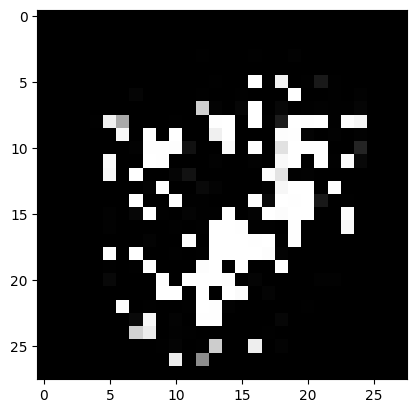

Epoch: 48550
loss_g: 0.09579922258853912 	loss_d: 4.019160270690918
Epoch: 48600
loss_g: 0.0957636833190918 	loss_d: 3.7557902336120605
Epoch: 48650
loss_g: 0.09565717726945877 	loss_d: 3.660097599029541
Epoch: 48700
loss_g: 0.09545423090457916 	loss_d: 3.705503463745117
Epoch: 48750
loss_g: 0.09543991088867188 	loss_d: 3.7885775566101074
Epoch: 48800
loss_g: 0.09542851895093918 	loss_d: 3.834869861602783
Epoch: 48850
loss_g: 0.09536117315292358 	loss_d: 3.537233352661133
Epoch: 48900
loss_g: 0.09527061134576797 	loss_d: 3.4469501972198486
Epoch: 48950
loss_g: 0.09526032209396362 	loss_d: 3.860200881958008
Epoch: 49000
loss_g: 0.09517102688550949 	loss_d: 3.9339096546173096


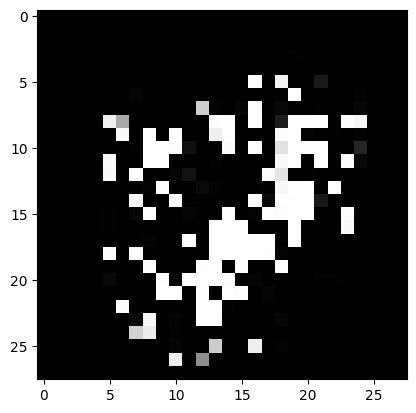

Epoch: 49050
loss_g: 0.09518028795719147 	loss_d: 3.67983341217041
Epoch: 49100
loss_g: 0.09501489251852036 	loss_d: 3.6017370223999023
Epoch: 49150
loss_g: 0.09497322142124176 	loss_d: 3.8104119300842285
Epoch: 49200
loss_g: 0.09496360272169113 	loss_d: 3.384429693222046
Epoch: 49250
loss_g: 0.0949028953909874 	loss_d: 3.774491310119629
Epoch: 49300
loss_g: 0.09474493563175201 	loss_d: 3.7092113494873047
Epoch: 49350
loss_g: 0.09468934684991837 	loss_d: 3.753926992416382
Epoch: 49400
loss_g: 0.09467319399118423 	loss_d: 3.653416156768799
Epoch: 49450
loss_g: 0.09445834904909134 	loss_d: 3.6273982524871826
Epoch: 49500
loss_g: 0.09454499930143356 	loss_d: 3.692070960998535


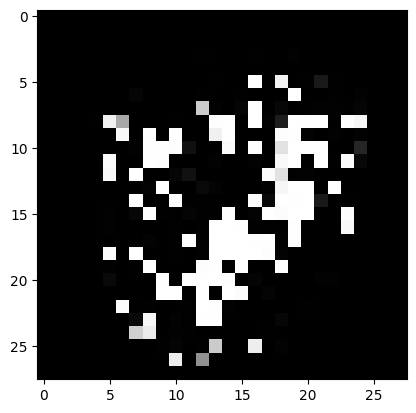

Epoch: 49550
loss_g: 0.09429731220006943 	loss_d: 3.712462902069092
Epoch: 49600
loss_g: 0.09428222477436066 	loss_d: 3.523149251937866
Epoch: 49650
loss_g: 0.09436743706464767 	loss_d: 3.914425849914551
Epoch: 49700
loss_g: 0.09421440958976746 	loss_d: 3.399395704269409
Epoch: 49750
loss_g: 0.09416680783033371 	loss_d: 3.6729955673217773
Epoch: 49800
loss_g: 0.09416784346103668 	loss_d: 3.6409051418304443
Epoch: 49850
loss_g: 0.09412302076816559 	loss_d: 3.5701961517333984
Epoch: 49900
loss_g: 0.09403028339147568 	loss_d: 3.7262778282165527
Epoch: 49950
loss_g: 0.09391195327043533 	loss_d: 3.9155454635620117
Epoch: 50000
loss_g: 0.09383915364742279 	loss_d: 3.5700860023498535


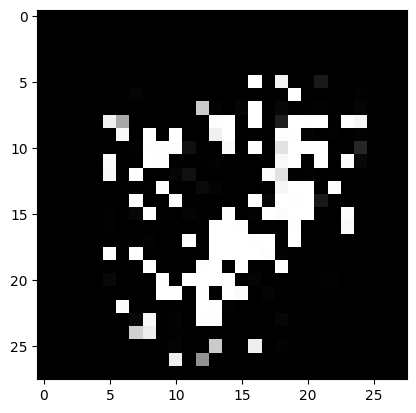

Epoch: 50050
loss_g: 0.09371912479400635 	loss_d: 3.691103458404541
Epoch: 50100
loss_g: 0.09372096508741379 	loss_d: 3.5265021324157715
Epoch: 50150
loss_g: 0.09369059652090073 	loss_d: 3.4106597900390625
Epoch: 50200
loss_g: 0.09358249604701996 	loss_d: 3.4622390270233154
Epoch: 50250
loss_g: 0.09369141608476639 	loss_d: 3.5717029571533203
Epoch: 50300
loss_g: 0.09341926127672195 	loss_d: 3.4098727703094482
Epoch: 50350
loss_g: 0.09340272098779678 	loss_d: 3.429384708404541
Epoch: 50400
loss_g: 0.0934414491057396 	loss_d: 4.3127851486206055
Epoch: 50450
loss_g: 0.09327403455972672 	loss_d: 3.506437301635742
Epoch: 50500
loss_g: 0.09326203912496567 	loss_d: 3.7731475830078125


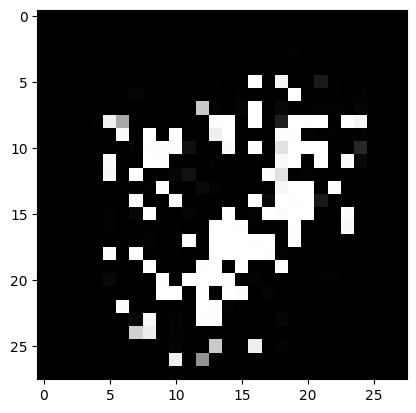

Epoch: 50550
loss_g: 0.09317851811647415 	loss_d: 3.6162562370300293
Epoch: 50600
loss_g: 0.0931074470281601 	loss_d: 3.834430694580078


KeyboardInterrupt: 

In [5]:
lr = 0.01
k = 5
epochs = 100000

generator = Generator().to(device)
disciminator = Discriminator().to(device)

optimizer_gen = torch.optim.SGD(generator.parameters(), lr=lr)
optimizer_dis = torch.optim.SGD(disciminator.parameters(), lr=lr)

criterion_gen = torch.nn.BCEWithLogitsLoss()
criterion_dis = torch.nn.BCEWithLogitsLoss()

scheduler_gen = torch.optim.lr_scheduler.StepLR(optimizer_gen, step_size=25, gamma=0.998)
scheduler_dis = torch.optim.lr_scheduler.StepLR(optimizer_dis, step_size=25, gamma=0.998)

train_models(disciminator, criterion_dis, optimizer_dis, scheduler_dis, generator, criterion_gen, optimizer_gen, scheduler_gen, epochs, train_loader, k, batch_size)